In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from natsort import natsorted
import scipy.stats as stats
import networkx as nx

# Complexity Reduction for Causal Model Discovery in Cancer Genomics
#### First Notebook (this one)
0. Explore the Patient and Tumor datasets to undertand the data and group the categorical variables
1. Filter the MAF file, removing all Passengers genes and Keeping the drivers
2. For each SuperPathway, create a dataframe intersecting the drivers in each patient
3. Include in each dataframe the categorical information about patient and tumour
    1. Create 2 DFs, considering Table 1 and Table 2 from the text
#### Second notebook
4. For each dataframe, create a Causal Model and save as network
#### Third notebook
5. Join the CMs into a final CM with edge weight


<hr>

##### Read the input files

In [2]:
%%time
drivers = set(pd.read_csv("1 - Input/NCG_cancerdrivers_systemslevelproperties.tsv",sep="\t")["symbol"])
MAF = pd.read_csv("C:/Users/ragna/DOUTORADO datasets/data_mutations.txt",sep="\t",low_memory=False,skiprows=1)
sampleDF = pd.read_csv("1 - Input/data_clinical_sample.txt",sep="\t",comment='#')
patientDF = pd.read_csv("1 - Input/data_clinical_patient.txt",sep="\t",comment='#')

CPU times: total: 12 s
Wall time: 13.6 s


In [3]:
superPathwaysNames=set(["Autophagy","Cell Cycle","Cell-Cell communication","Cellular responses to stimuli","Chromatin organization","Circadian Clock","Developmental Biology","Digestion and absorption","DNA Repair","DNA Replication","Extracellular matrix organization","Gene expression (Transcription)","Hemostasis","Immune System","Metabolism","Metabolism of proteins","Metabolism of RNA","Muscle contraction","Neuronal System","Organelle biogenesis and maintenance","Programmed Cell Death","Protein localization","Reproduction","Sensory Perception","Signal Transduction","Transport of small molecules","Vesicle-mediated transport"])
print(len(superPathwaysNames))
superPathways={}

file_path = "1 - Input/ReactomePathways.gmt" 
with open(file_path, "r") as file:
    for line in file:
        sp = line.strip().split("\t")
        if sp[0] in superPathwaysNames:
            superPathways[sp[0]]=sp[2:]


27


## Exploratory Analisys for my Thesis

In [10]:
MAF.Variant_Classification.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

Variant_Classification
Missense_Mutation         65.82%
Silent                    22.56%
Nonsense_Mutation           5.2%
Frame_Shift_Del            2.15%
Splice_Site                 2.1%
Frame_Shift_Ins            0.63%
Splice_Region               0.6%
RNA                        0.31%
In_Frame_Del               0.23%
Intron                     0.17%
Nonstop_Mutation           0.09%
3'UTR                      0.03%
3'Flank                    0.03%
In_Frame_Ins               0.03%
5'Flank                    0.03%
5'UTR                      0.03%
Translation_Start_Site     0.01%
IGR                         0.0%
Name: proportion, dtype: object

In [52]:
def plotDistributionWithInfoAux(data,ylabel,xlabel):
    Q1 = round(np.quantile(data,.25))
    Q2 = round(np.quantile(data,.5))
    Q3 = round(np.quantile(data,.75))
    maximum = round(np.max(data))
    minimum = round(np.min(data))
    avg = round(np.average(data))

    plt.plot(data,".")
    plt.ylabel(ylabel,fontsize=12, fontweight='bold')
    plt.xlabel(xlabel)
    plt.title("\n\nQ1:"+str(Q1)+" | Q2:"+str(Q2)+" | Q3:"+str(Q3)+" | Avg:"+str(avg)+" | Max:"+str(maximum)+" | Min:"+str(minimum))
    plt.grid(color = 'gray', linestyle = '-', linewidth = 0.5)
    plt.tight_layout()

def plotHistogramAux(dfColumn, ylabel, xlabel):    
    # Calculate value counts and percentages
    valueCounts = dfColumn.value_counts()
    total = valueCounts.sum()
    percentages = (valueCounts / total) * 100
    
    # Get sorted labels and their corresponding values and percentages
    labels = natsorted(valueCounts.index)
    values = valueCounts[labels].values
    percent_values = percentages[labels].values

    # Create the plot
    bars = plt.bar(labels, values)
    
    # Add percentage labels on top of each bar
    for bar, percent in zip(bars, percent_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percent:.1f}%', ha='center', va='bottom')

    plt.xticks(rotation=0)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel,fontsize=12, fontweight='bold')
    plt.tight_layout()

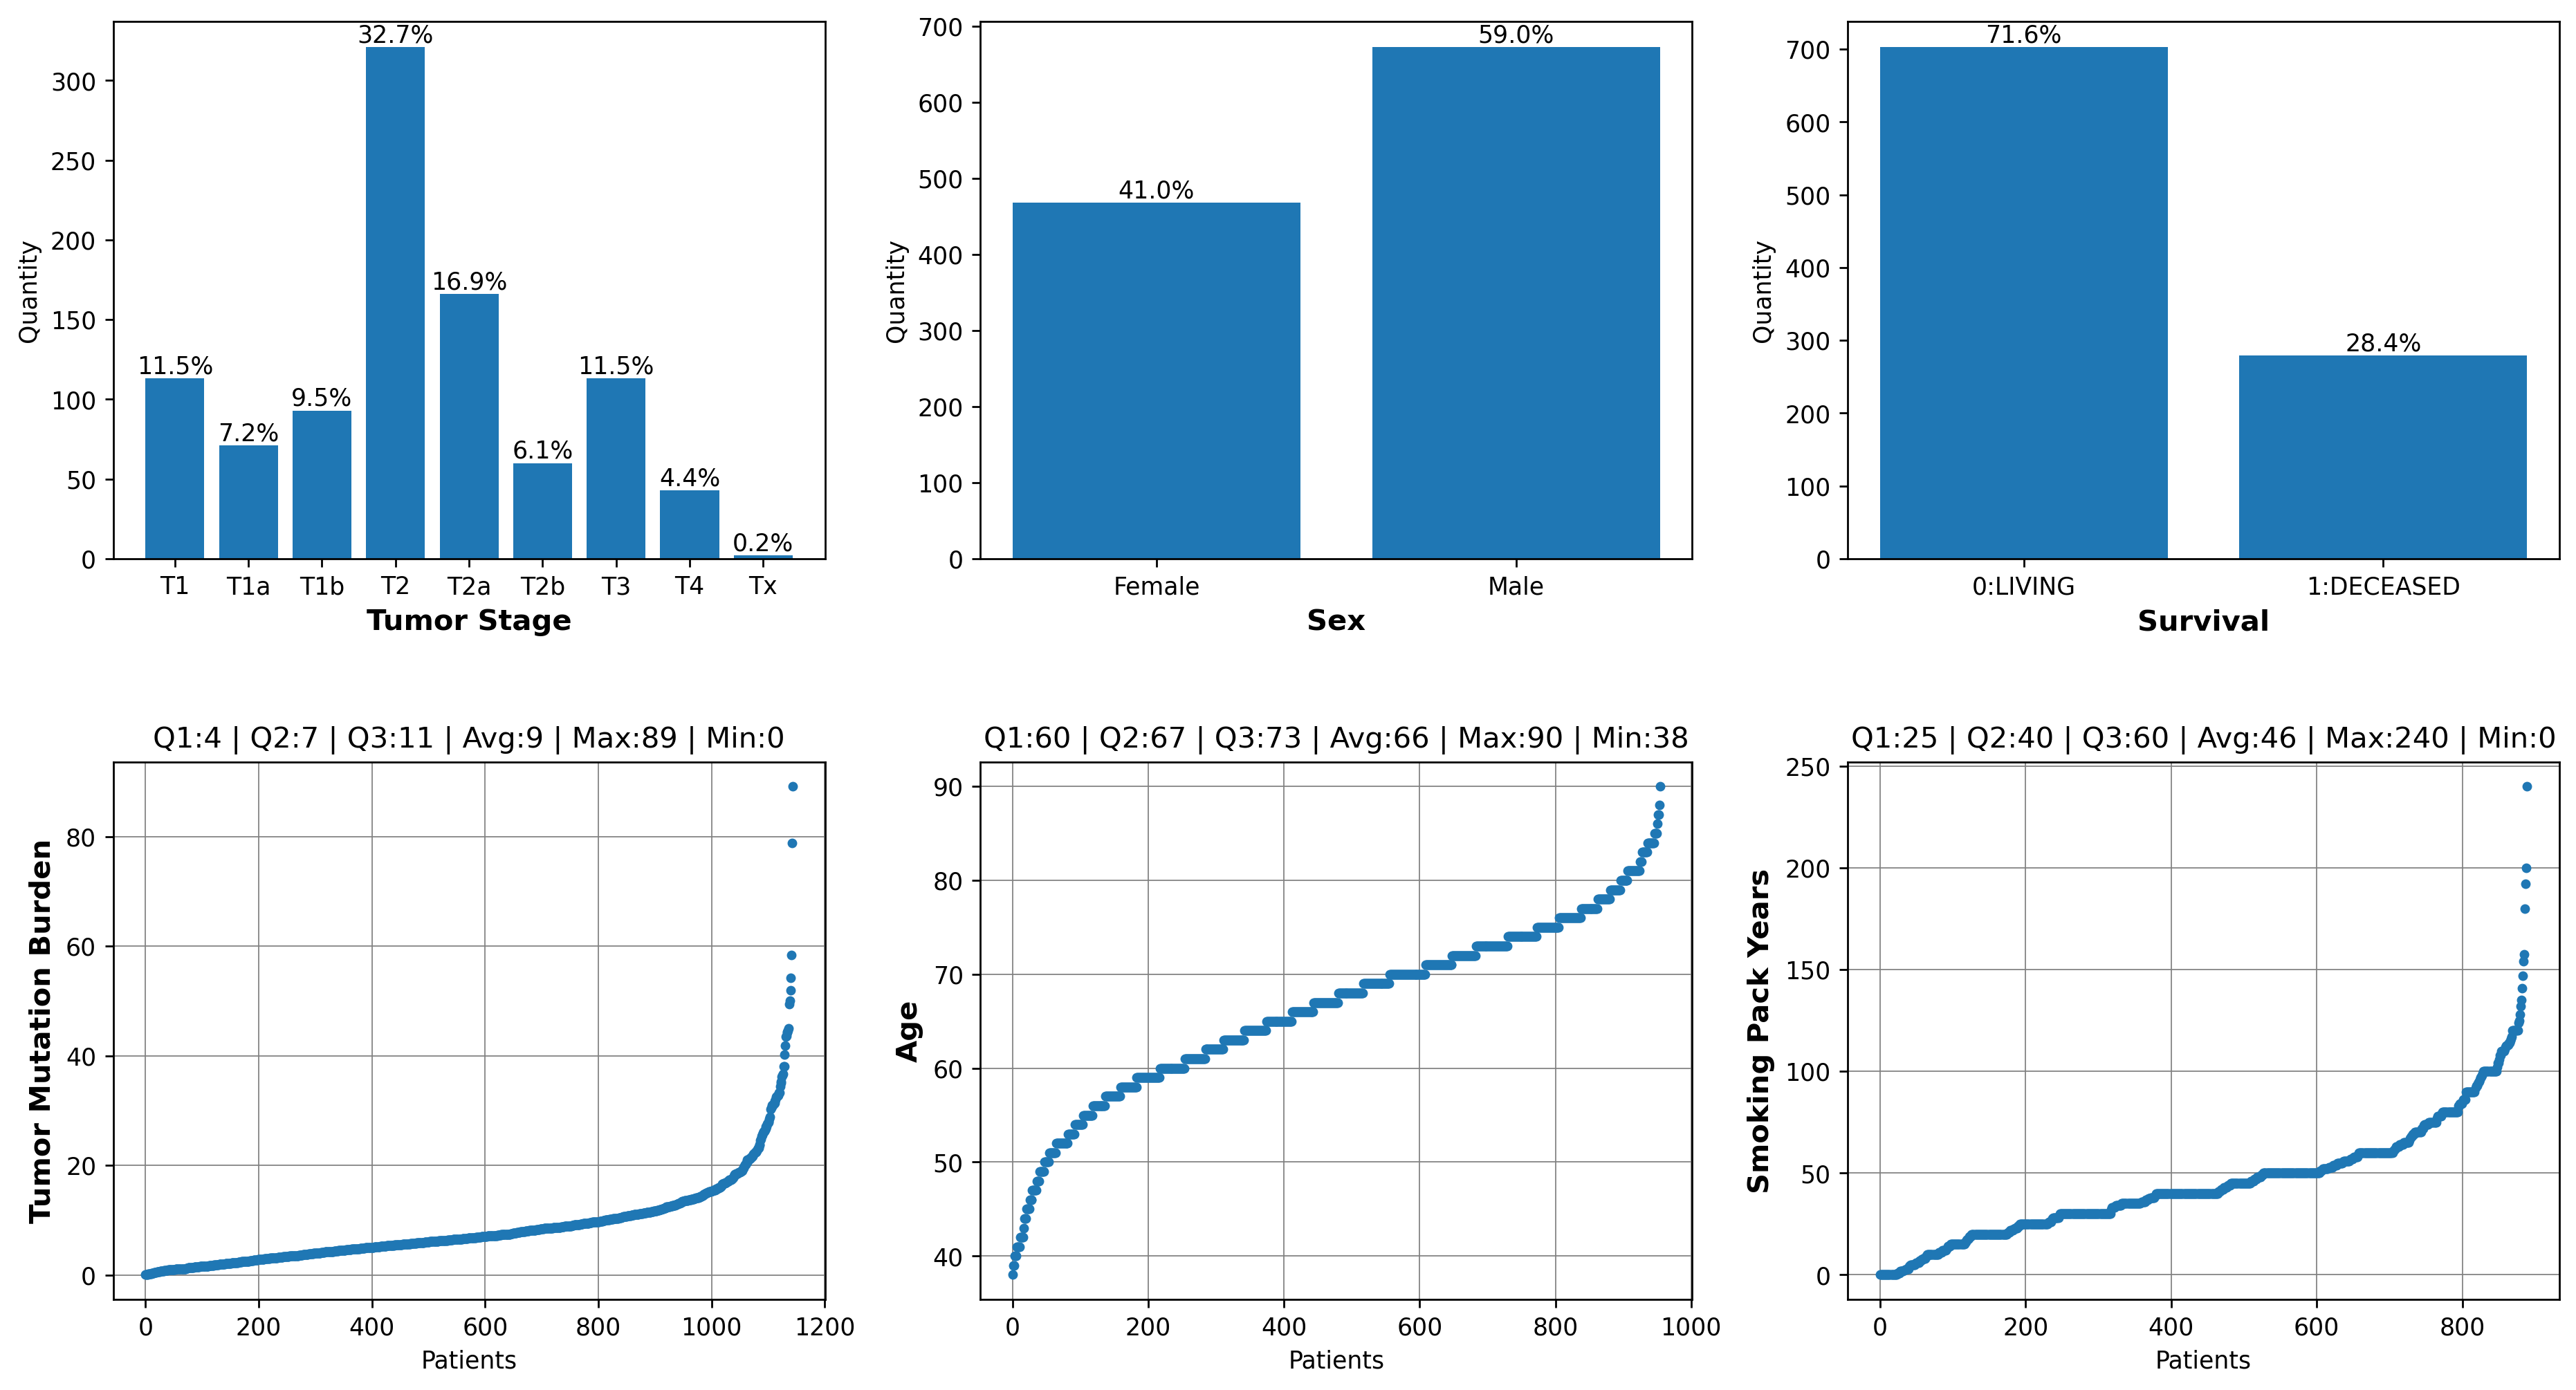

In [53]:
plt.figure(figsize=(15,12),dpi=250)

plt.subplot(3,3,1)
plotHistogramAux(sampleDF["T_STAGE"],"Quantity","Tumor Stage")
plt.subplot(3,3,2)
plotHistogramAux(patientDF.SEX,"Quantity","Sex")
plt.subplot(3,3,3)
plotHistogramAux(patientDF.OS_STATUS,"Quantity","Survival")
plt.subplot(3,3,4)
plotDistributionWithInfoAux(sorted(sampleDF["TMB_NONSYNONYMOUS"]),"Tumor Mutation Burden","Patients")
plt.subplot(3,3,5)
plotDistributionWithInfoAux(data=sorted(patientDF.AGE.dropna()),ylabel="Age",xlabel="Patients")
plt.subplot(3,3,6)
plotDistributionWithInfoAux(data=sorted(patientDF.SMOKING_PACK_YEARS.dropna()),ylabel="Smoking Pack Years",xlabel="Patients")

plt.tight_layout()
plt.show()
plt.close()

##### Functions

In [4]:
def plotDistributionWithInfo(data,saveName,ylabel,xlabel):
    Q1 = round(np.quantile(data,.25))
    Q2 = round(np.quantile(data,.5))
    Q3 = round(np.quantile(data,.75))
    maximum = round(np.max(data))
    minimum = round(np.min(data))
    avg = round(np.average(data))

    plt.figure(figsize=(5.5,4),dpi=350)
    plt.plot(data,".")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title("Q1:"+str(Q1)+" | Q2:"+str(Q2)+" | Q3:"+str(Q3)+" | Avg:"+str(avg)+" | Max:"+str(maximum)+" | Min:"+str(minimum))
    plt.grid(color = 'gray', linestyle = '-', linewidth = 0.5)
    plt.tight_layout()
    plt.savefig("1 - Output/imgs/"+saveName+".png")
    plt.show()
    plt.close()

def plotHistogram(dfColumn,saveName,ylabel,xlabel):    
    valueCounts=dict(dfColumn.value_counts())
    labels=natsorted(valueCounts.keys())
    values=[]
    for l in labels:
        values.append(valueCounts[l])

    plt.figure(figsize=(5.5,4),dpi=350)
    plt.bar(labels,values)
    plt.xticks(rotation=20)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.savefig("1 - Output/imgs/"+saveName+".png")
    plt.show()
    plt.close()

def discretizeIngroups(data,numberOfBins):
    min=np.min(data)
    max=np.max(data)
    binRange = (max-min)/numberOfBins

    bin=[min]
    for i in range(numberOfBins):
        bin.append(min+(binRange*(i+1)))

    labels=[]
    for i in range(len(bin)-1):
        labels.append(str(round(bin[i]))+"-"+str(round(bin[i+1])))

    return pd.cut(data, bins=bin, labels=labels)

<hr>

### 0. Explore the Patient and Tumor datasets to undertand the data and group the categorical variables
On the Tumor dataset, we are interested in the STAGE and also in the TMB:<br>
* TMB stands for "Tumor Mutational Burden." It refers to the total amount of genetic mutations present in the DNA of a tumor cell.A high TMB may indicate a greater likelihood of response to immunotherapy.
* TMB is continuous, so I need to categorize the data in to bins. I going to use percentiles.

In [5]:
sampleDF=sampleDF[["T_STAGE","TMB_NONSYNONYMOUS","PATIENT_ID","SAMPLE_ID"]]
sampleDF=sampleDF.rename(columns={'TMB_NONSYNONYMOUS': 'TMB'})

nan_count_per_column = sampleDF.isna().sum()
print("NaN count per column:")
print(nan_count_per_column)
sampleDF.head()

NaN count per column:
T_STAGE       162
TMB             0
PATIENT_ID      0
SAMPLE_ID       0
dtype: int64


,T_STAGE,TMB,PATIENT_ID,SAMPLE_ID
0,NaN,7.933333,LUAD-2GUGK,LUAD-2GUGK-Tumor
1,NaN,1.033333,LUAD-5O6B5,LUAD-5O6B5-Tumor
2,NaN,49.433333,LUAD-5V8LT,LUAD-5V8LT-Tumor
3,NaN,7.800000,LUAD-74TBW,LUAD-74TBW-Tumor
4,NaN,5.333333,LUAD-AEIUF,LUAD-AEIUF-Tumor


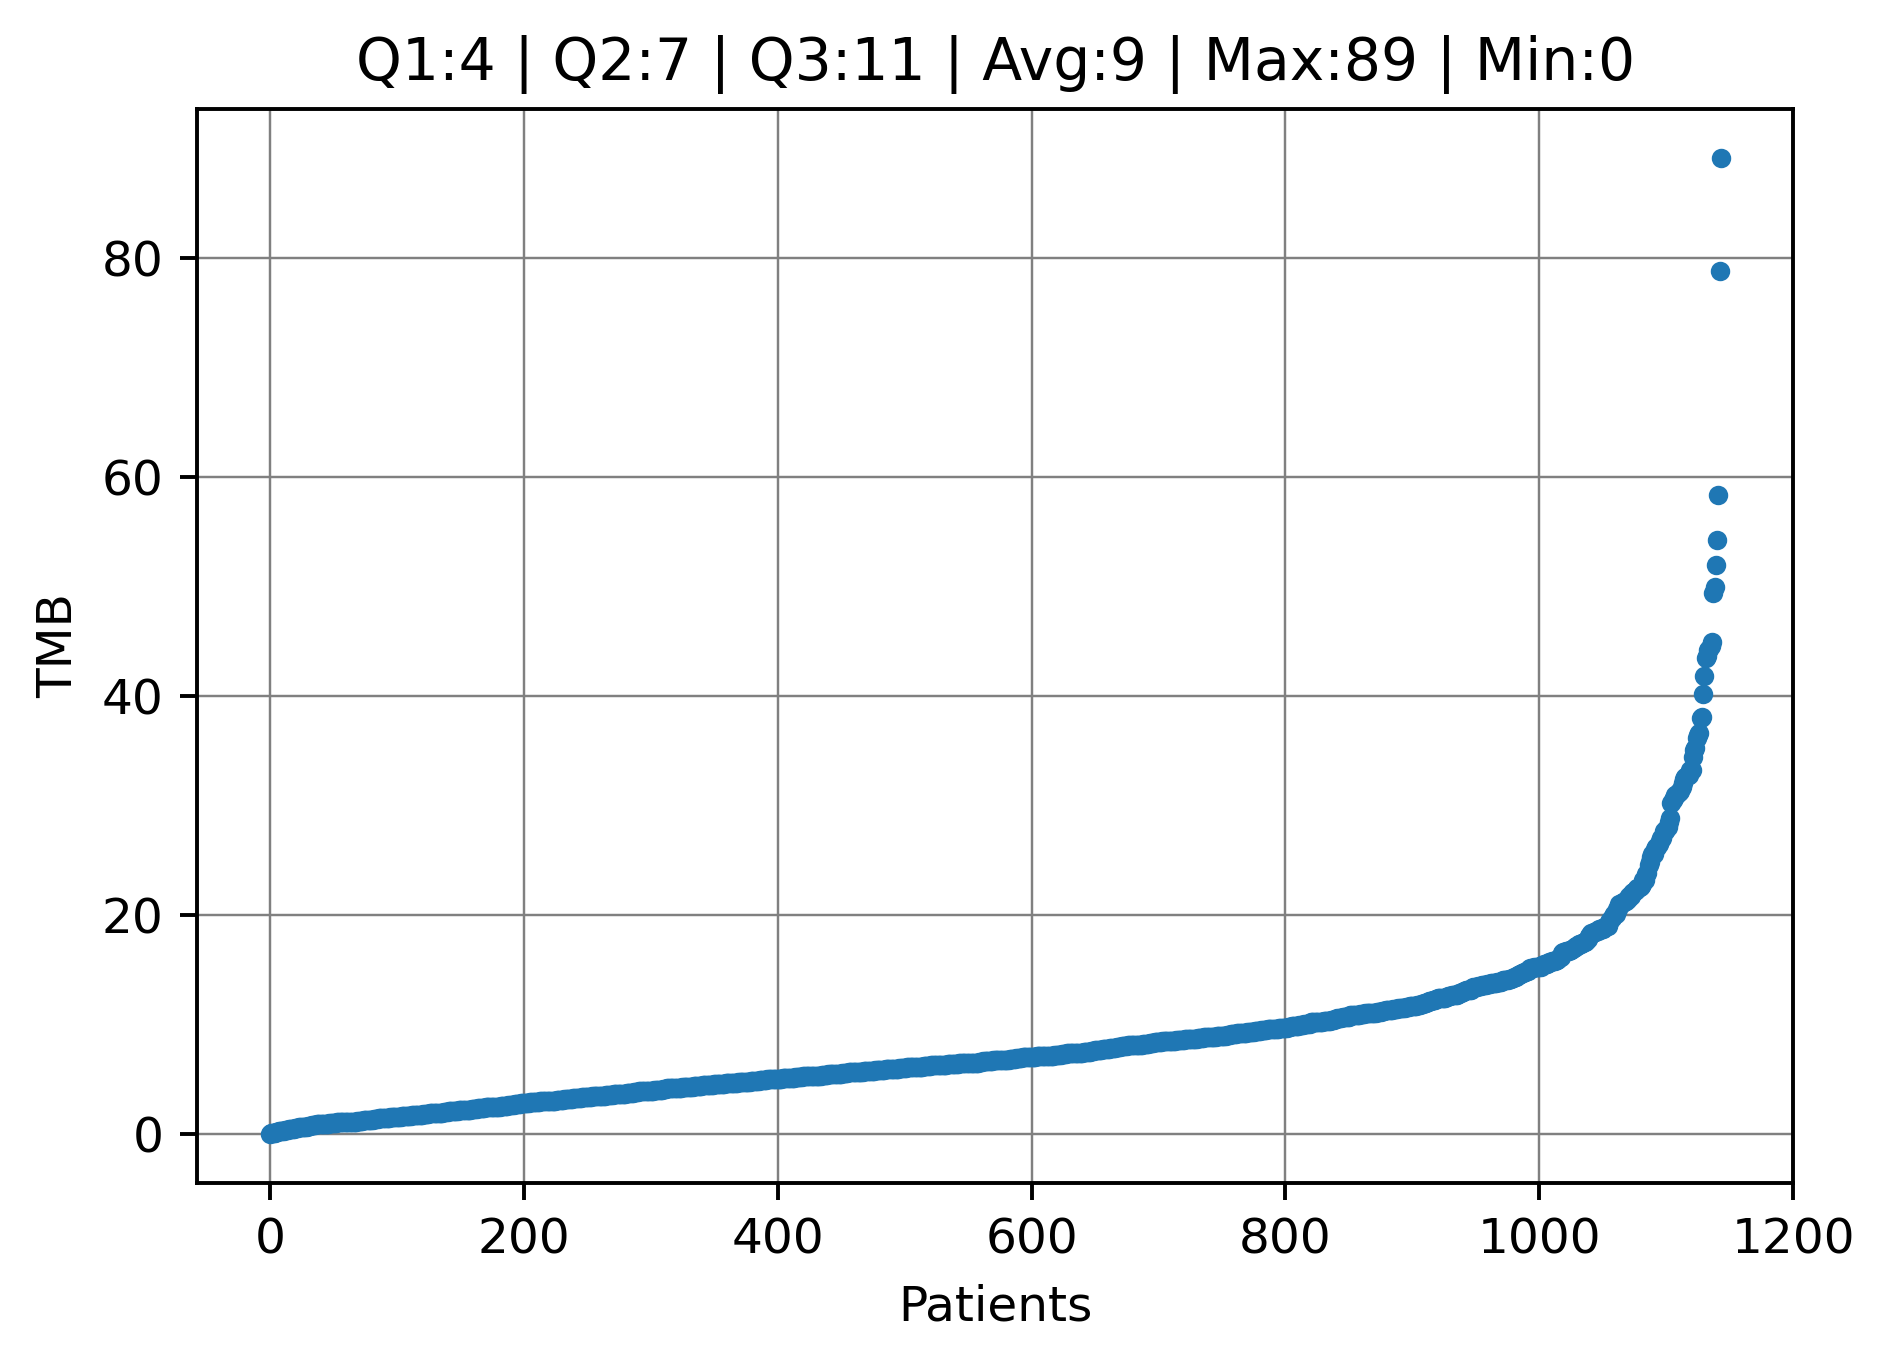

In [6]:
plotDistributionWithInfo(data=sorted(sampleDF.TMB),saveName="TMB Distribution",ylabel="TMB",xlabel="Patients")

### Remove TMB outliers

In [7]:
print(sampleDF.shape)
data=sorted(sampleDF.TMB)
q1 = np.quantile(data, .25)
q2 = np.quantile(data, .50)
q3 = np.quantile(data, .75)
iqr = q3 - q1
threshold = q3 + 4.5*iqr
sampleDF=sampleDF[sampleDF.TMB<threshold]
print(sampleDF.shape)

(1144, 4)
(1131, 4)


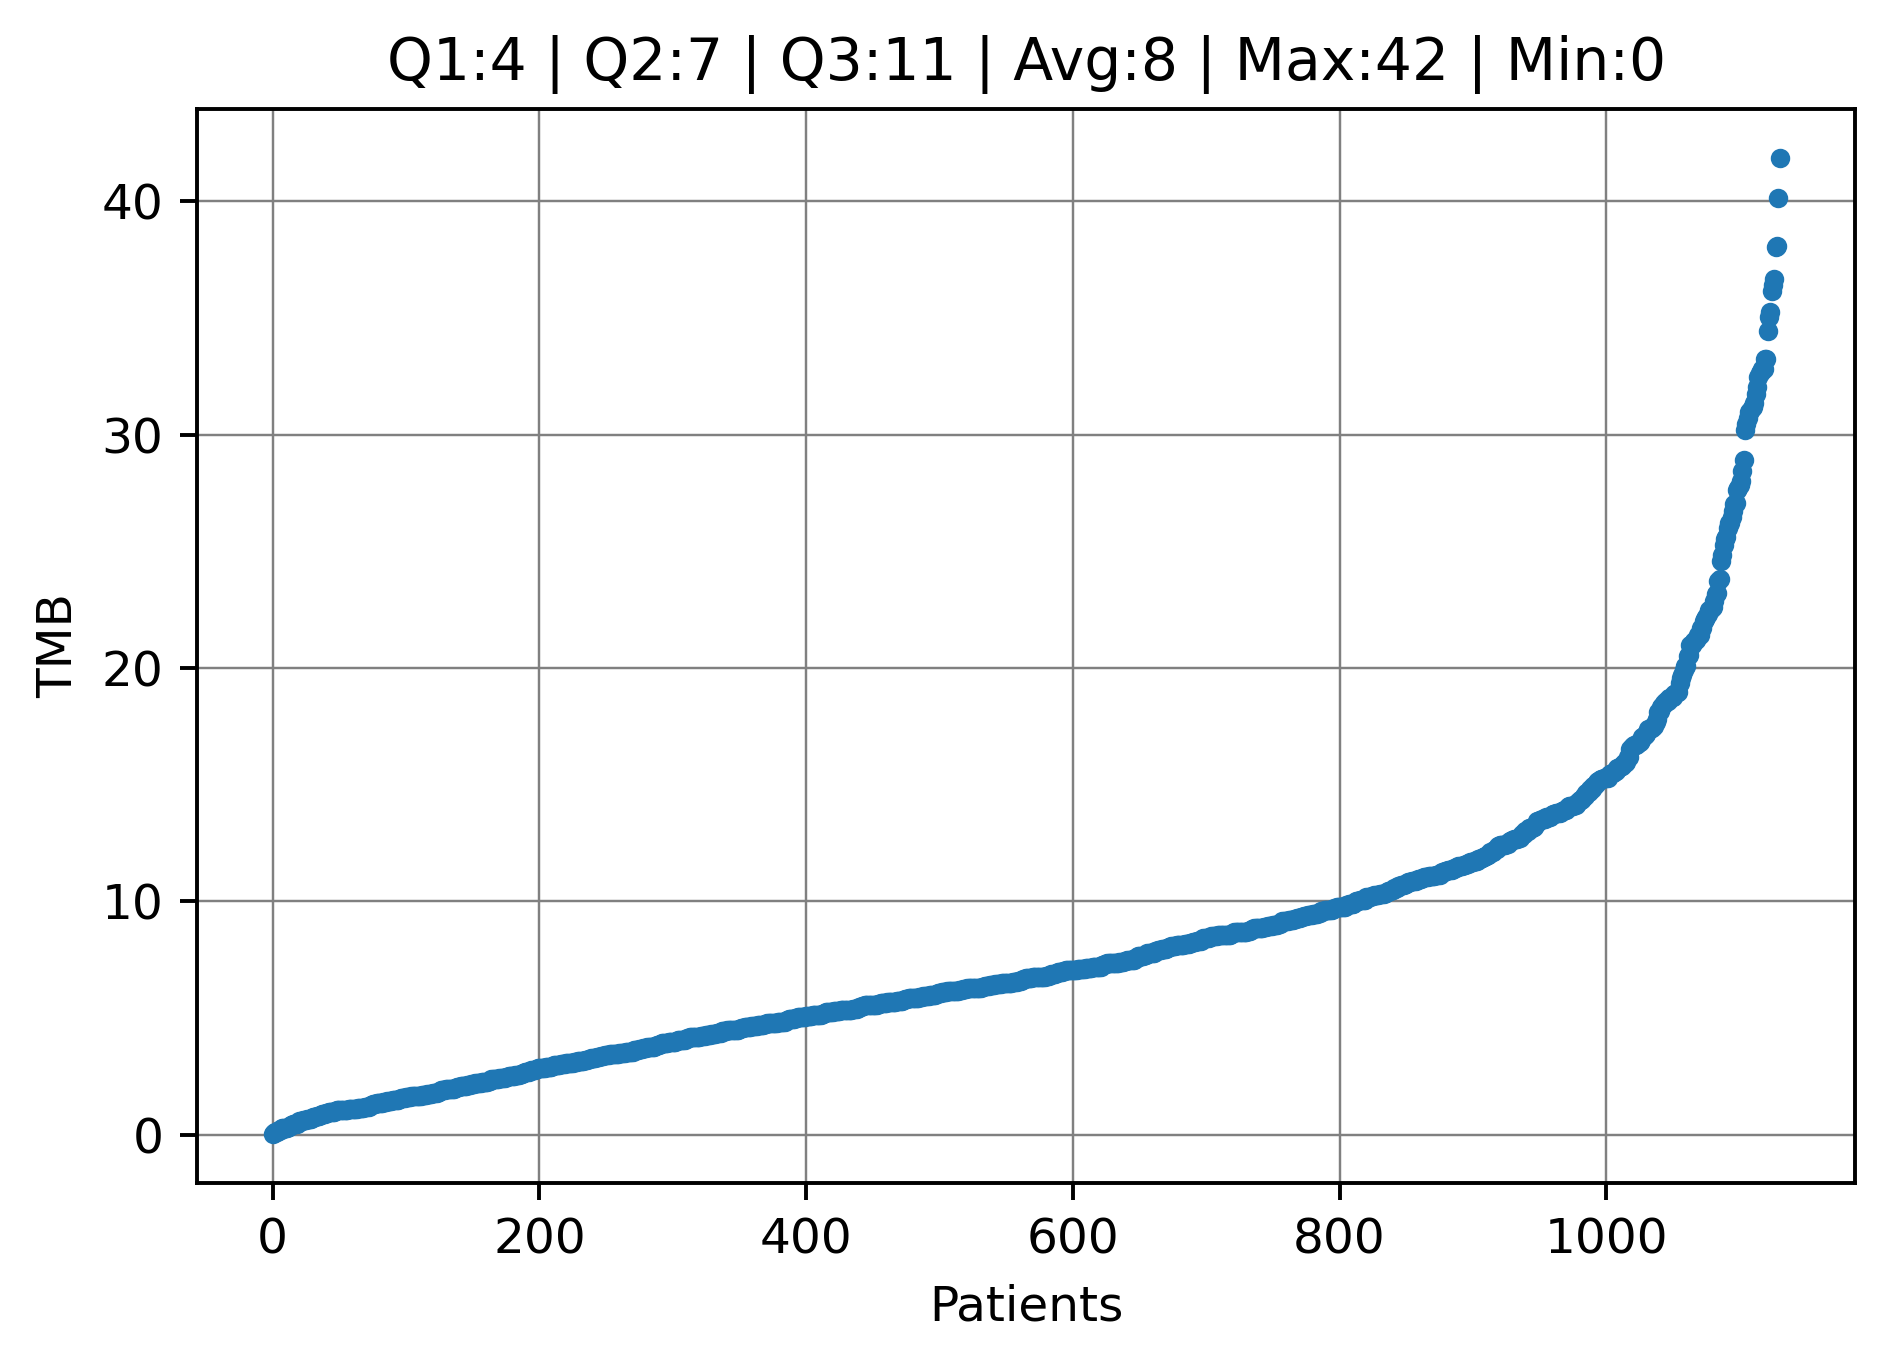

In [8]:
plotDistributionWithInfo(data=sorted(sampleDF.TMB),saveName="TMB Distribution Without Outlier",ylabel="TMB",xlabel="Patients")


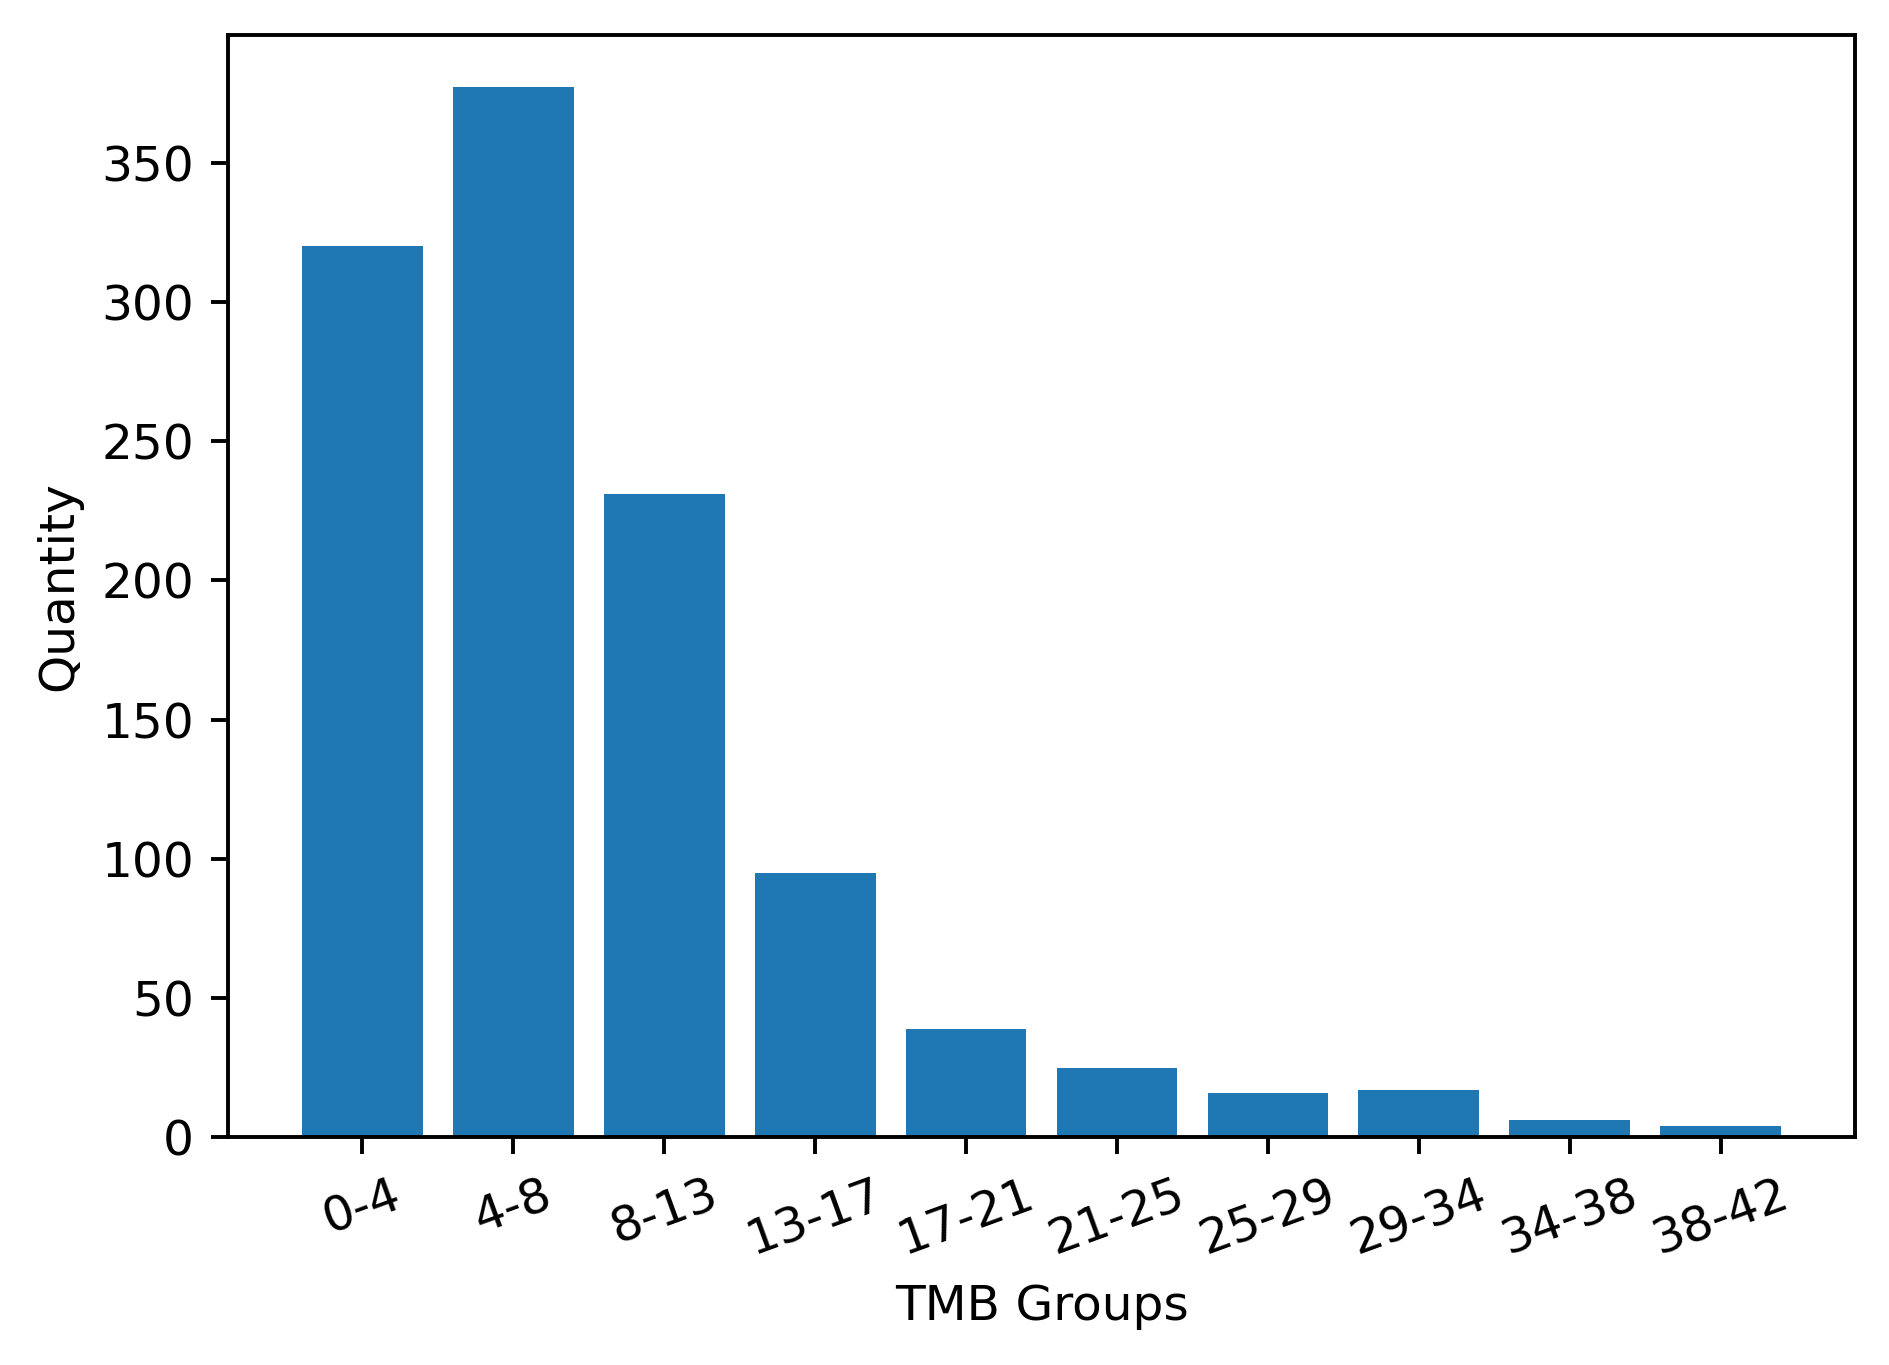

In [9]:
#discretize the continous variables
sampleDF["TMB_discrete"]=discretizeIngroups(sampleDF.TMB,10)
plotHistogram(sampleDF.TMB_discrete,saveName="TMB Distribution discrete",ylabel="Quantity",xlabel="TMB Groups")


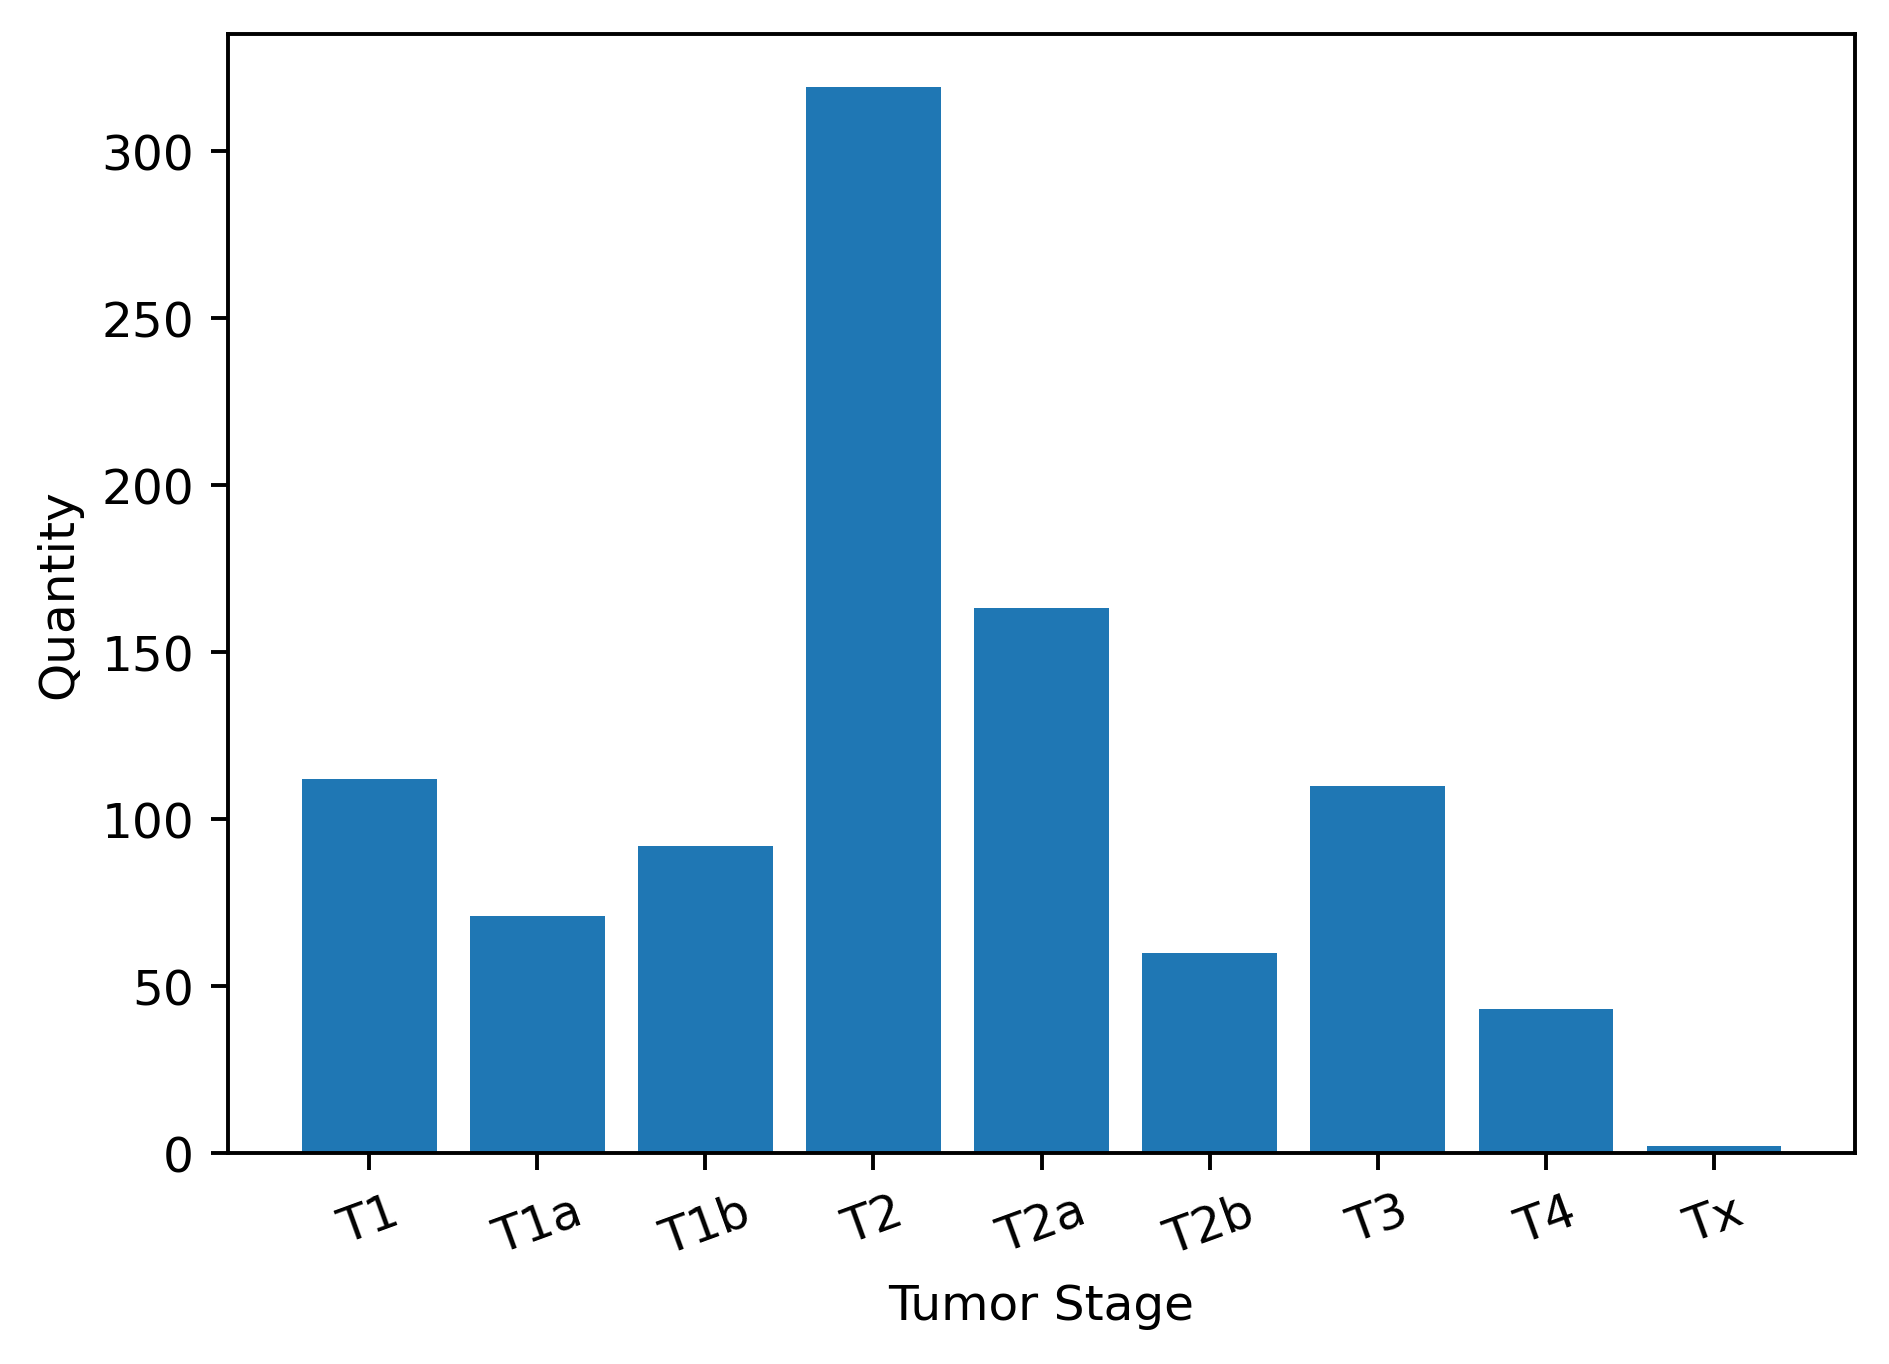

(1131, 5)


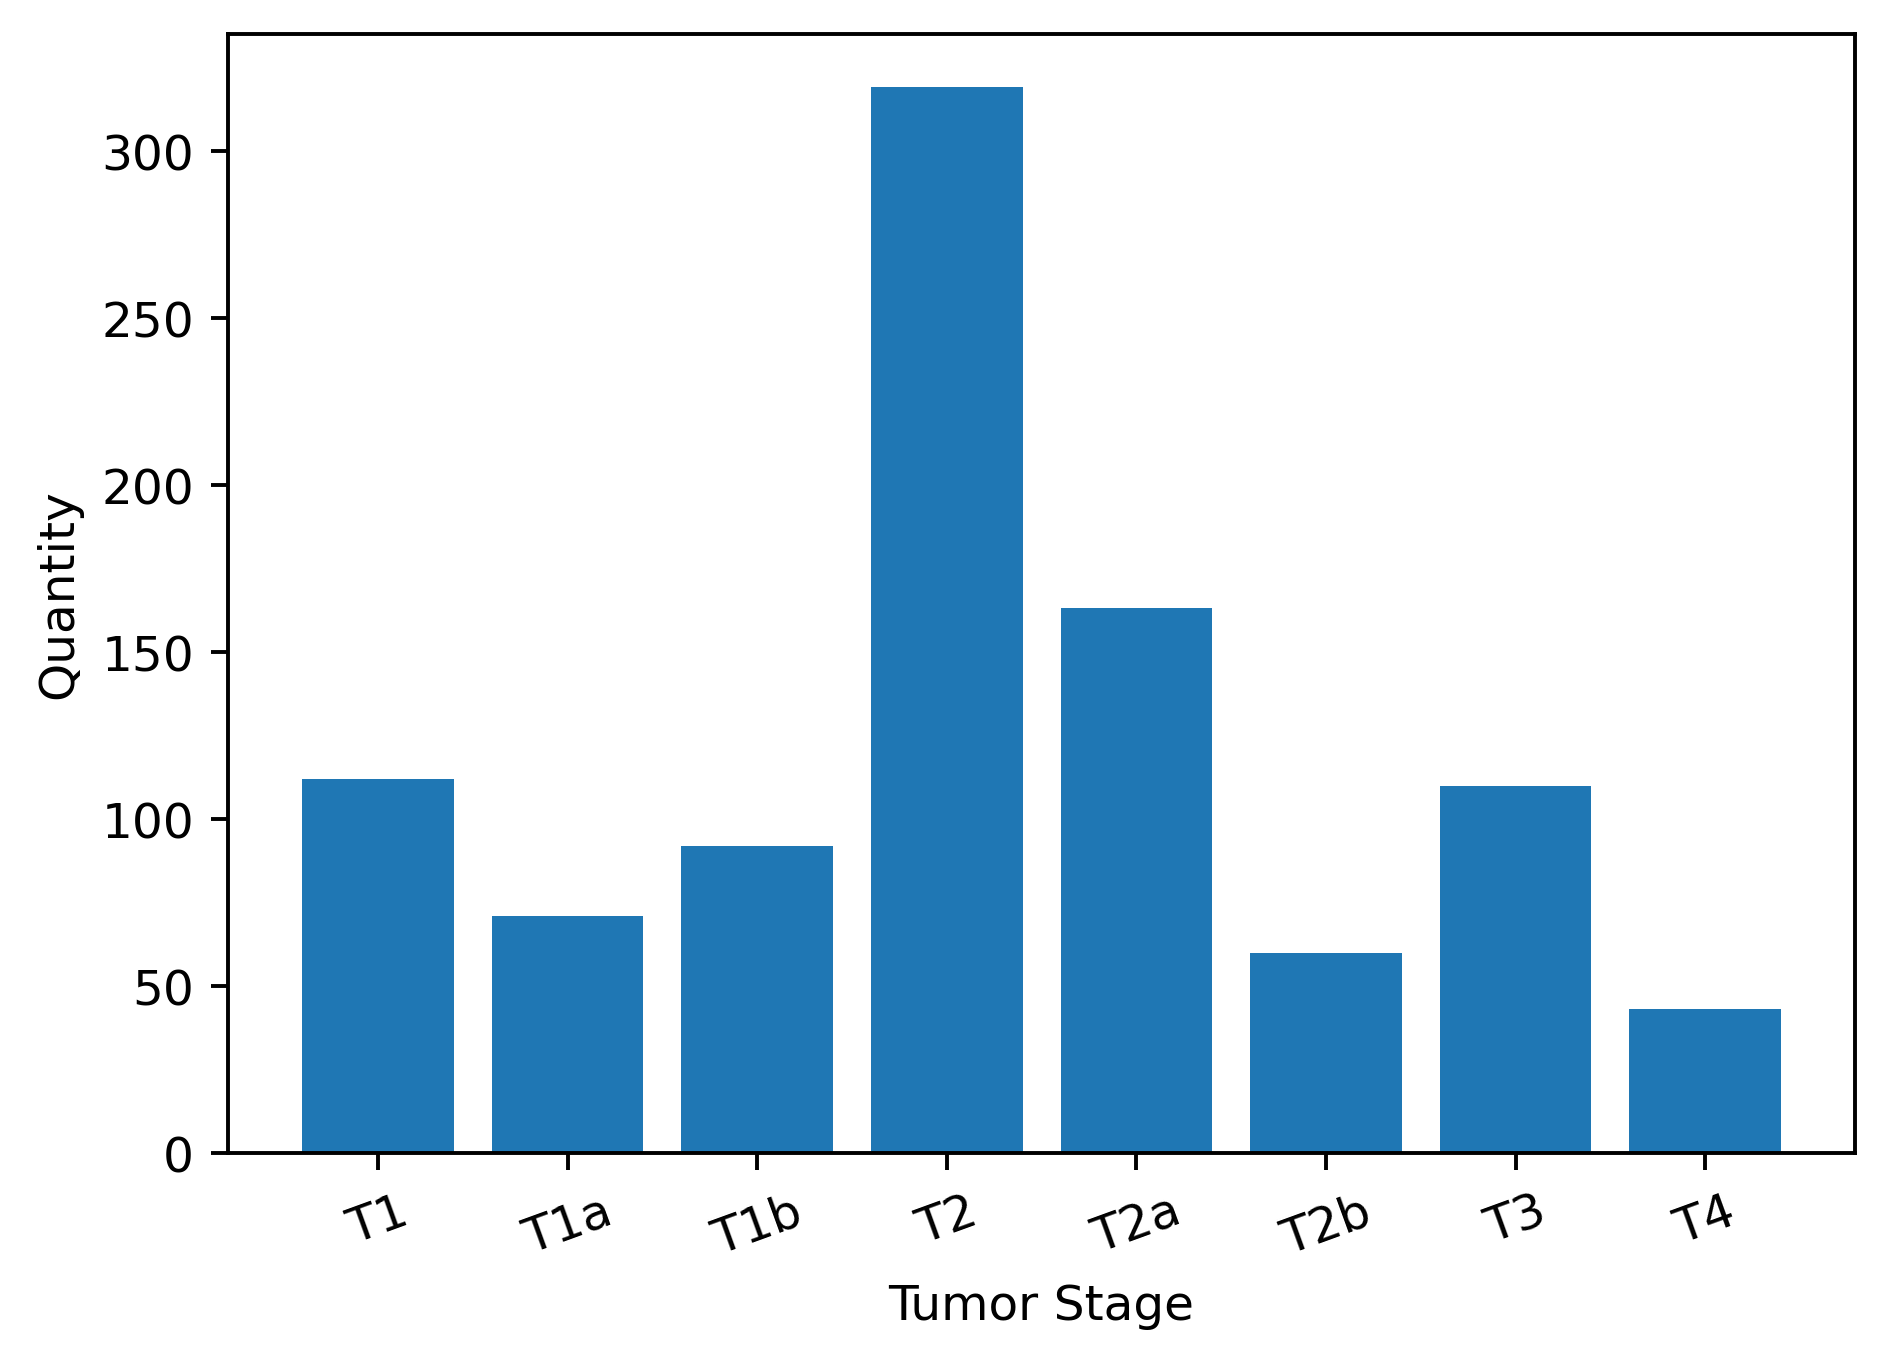

(1129, 5)


In [10]:
plotHistogram(sampleDF.T_STAGE,"tumorStageTumourFile","Quantity","Tumor Stage")
print(sampleDF.shape)
sampleDF=sampleDF[sampleDF.T_STAGE != "Tx"]
plotHistogram(sampleDF.T_STAGE,"tumorStageTumourFile-Preprocessed","Quantity","Tumor Stage")
print(sampleDF.shape)

<hr>

### Explore the Patient Dataset

In [11]:
patientDF=patientDF[["PATIENT_ID","AGE","SEX","SMOKING_HISTORY","SMOKING_PACK_YEARS","STAGE","OS_STATUS"]]
patientDF["SMOKING_HISTORY"]=patientDF["SMOKING_HISTORY"].replace("Current Reformed Smoker For < Or = 15 Years","Reformed <=15")
patientDF["SMOKING_HISTORY"]=patientDF["SMOKING_HISTORY"].replace("Current Reformed Smoker For > 15 Years","Reformed >15")
patientDF["SMOKING_HISTORY"]=patientDF["SMOKING_HISTORY"].replace("Lifelong Non-Smoker","Never Smoke")
patientDF["SMOKING_HISTORY"]=patientDF["SMOKING_HISTORY"].replace("Current Reformed Smoker, Duration Not Specified ","Reformed")

#discretize the continous variables
patientDF["AGE_discrete"]=discretizeIngroups(patientDF.AGE,10)

nan_count_per_column = patientDF.isna().sum()
print("NaN count per column:")
print(nan_count_per_column)
patientDF.head()

NaN count per column:
PATIENT_ID              0
AGE                   189
SEX                     3
SMOKING_HISTORY        57
SMOKING_PACK_YEARS    254
STAGE                  32
OS_STATUS             162
AGE_discrete          190
dtype: int64


,PATIENT_ID,AGE,SEX,SMOKING_HISTORY,SMOKING_PACK_YEARS,STAGE,OS_STATUS,AGE_discrete
0,LUAD-2GUGK,NaN,Female,Reformed,30.00,IIA,NaN,NaN
1,LUAD-5O6B5,NaN,Female,Never Smoke,0.00,IB,NaN,NaN
2,LUAD-5V8LT,NaN,Male,Reformed,6.00,IB,NaN,NaN
3,LUAD-74TBW,NaN,Male,Reformed,61.25,IB,NaN,NaN
4,LUAD-AEIUF,NaN,Female,Reformed,73.50,NaN,NaN,NaN


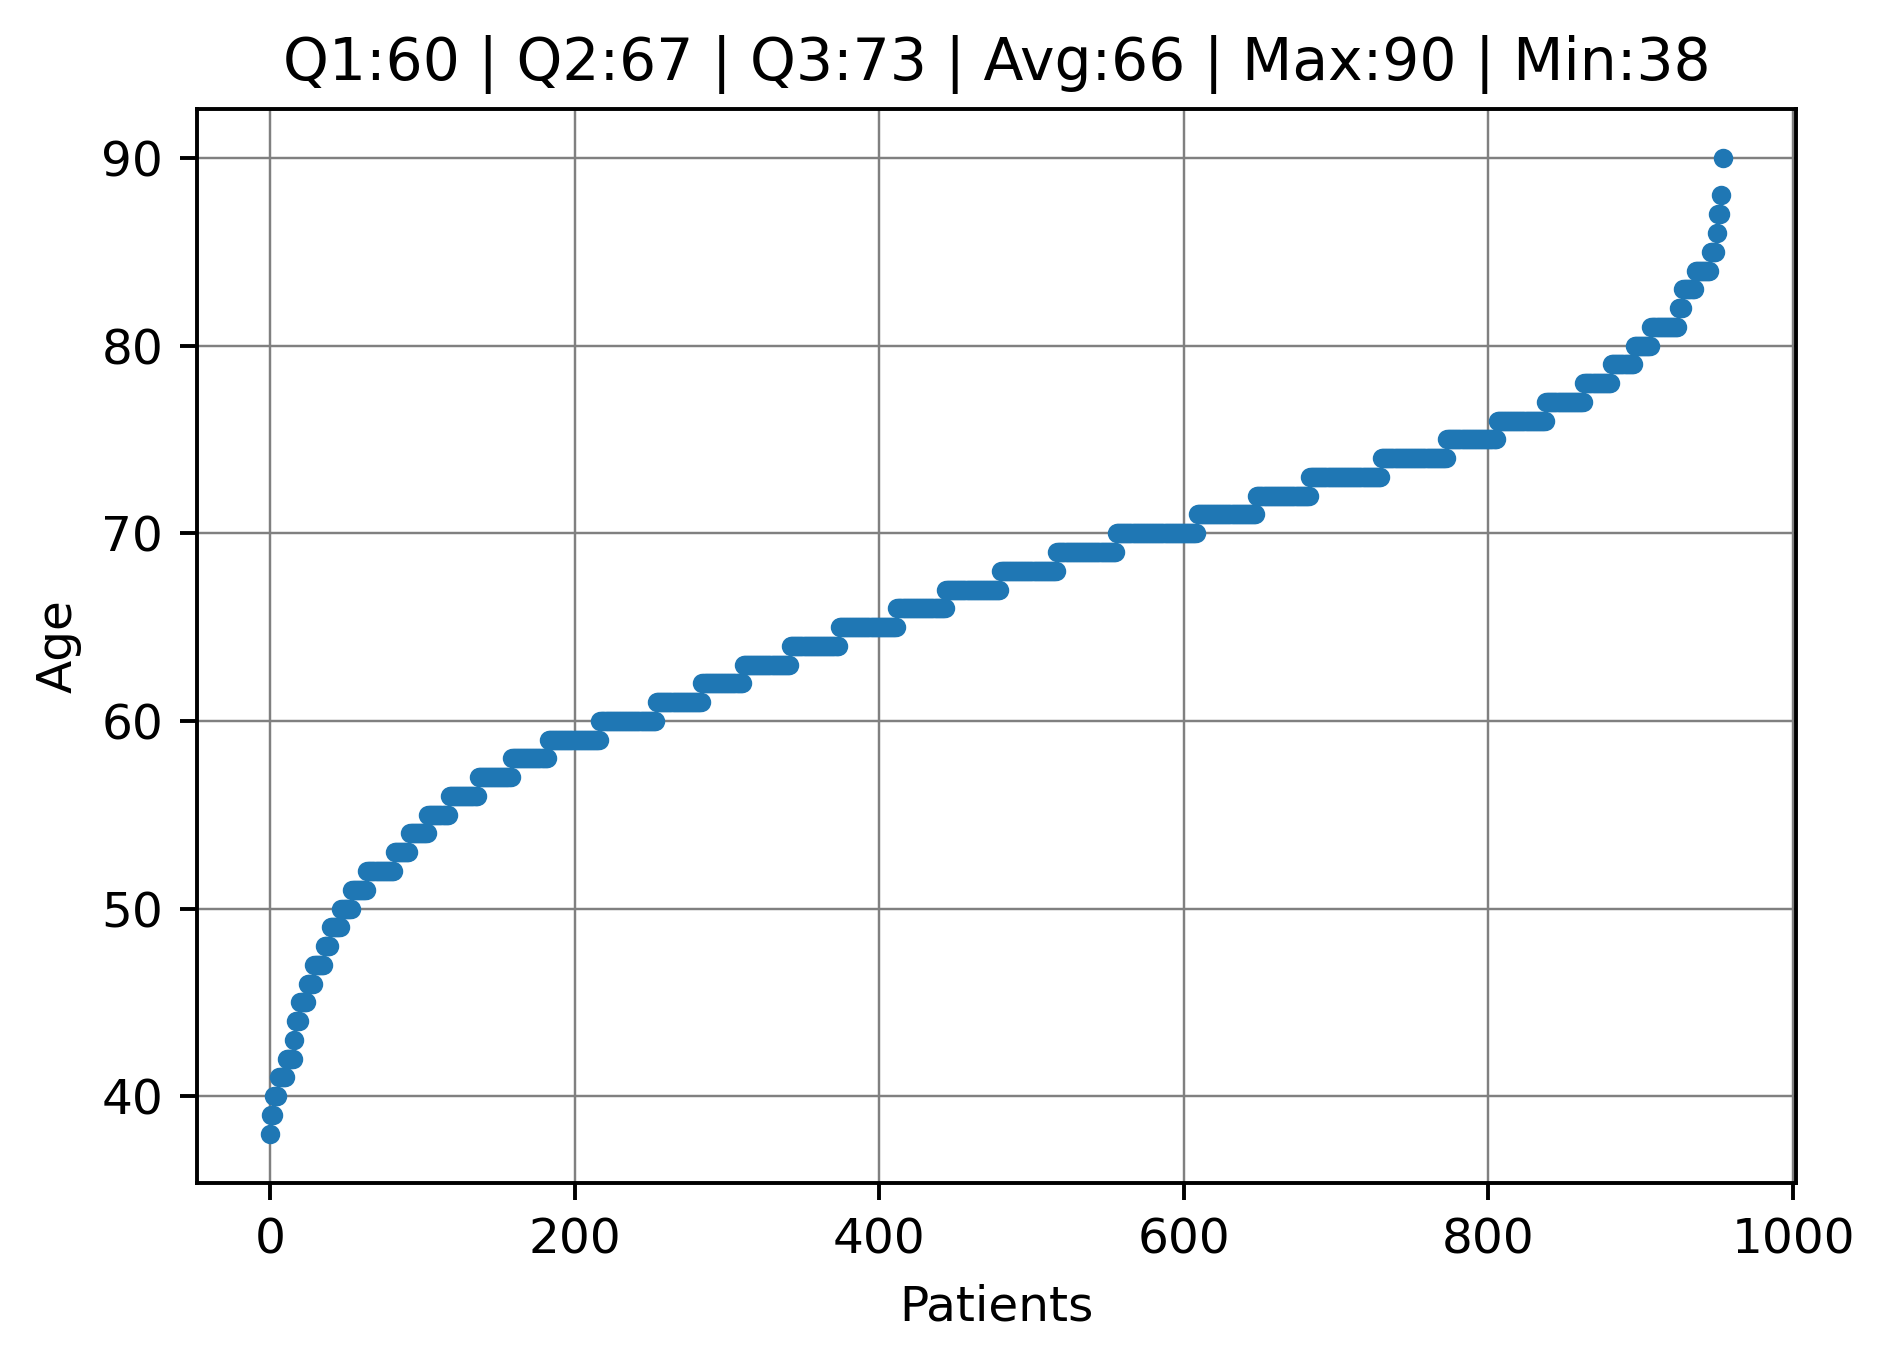

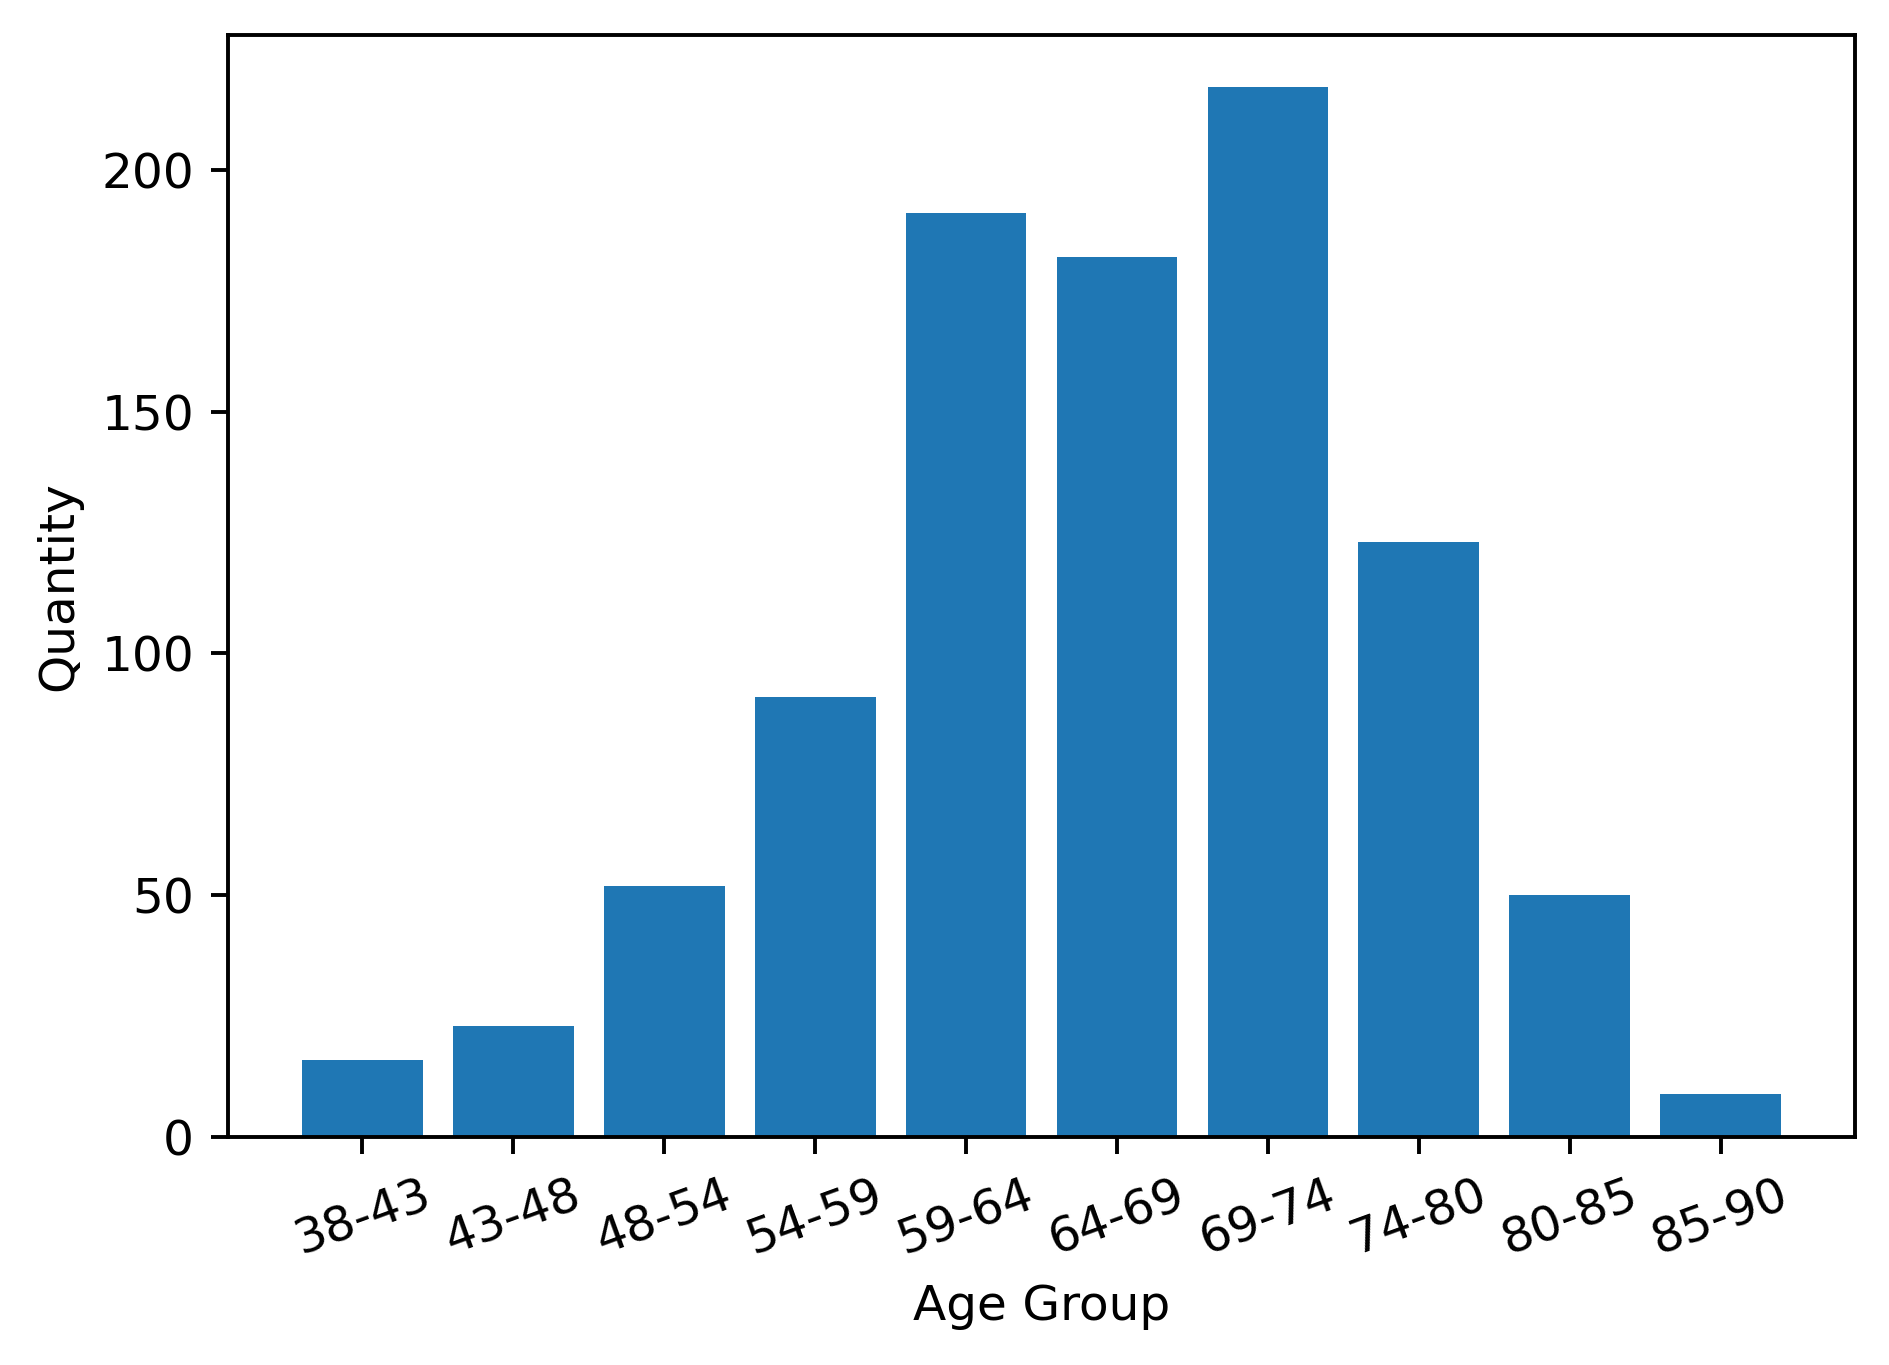

In [12]:
plotDistributionWithInfo(data=sorted(patientDF.AGE.dropna()),saveName="Age",ylabel="Age",xlabel="Patients")
plotHistogram(patientDF.AGE_discrete,"Age discrete","Quantity","Age Group")

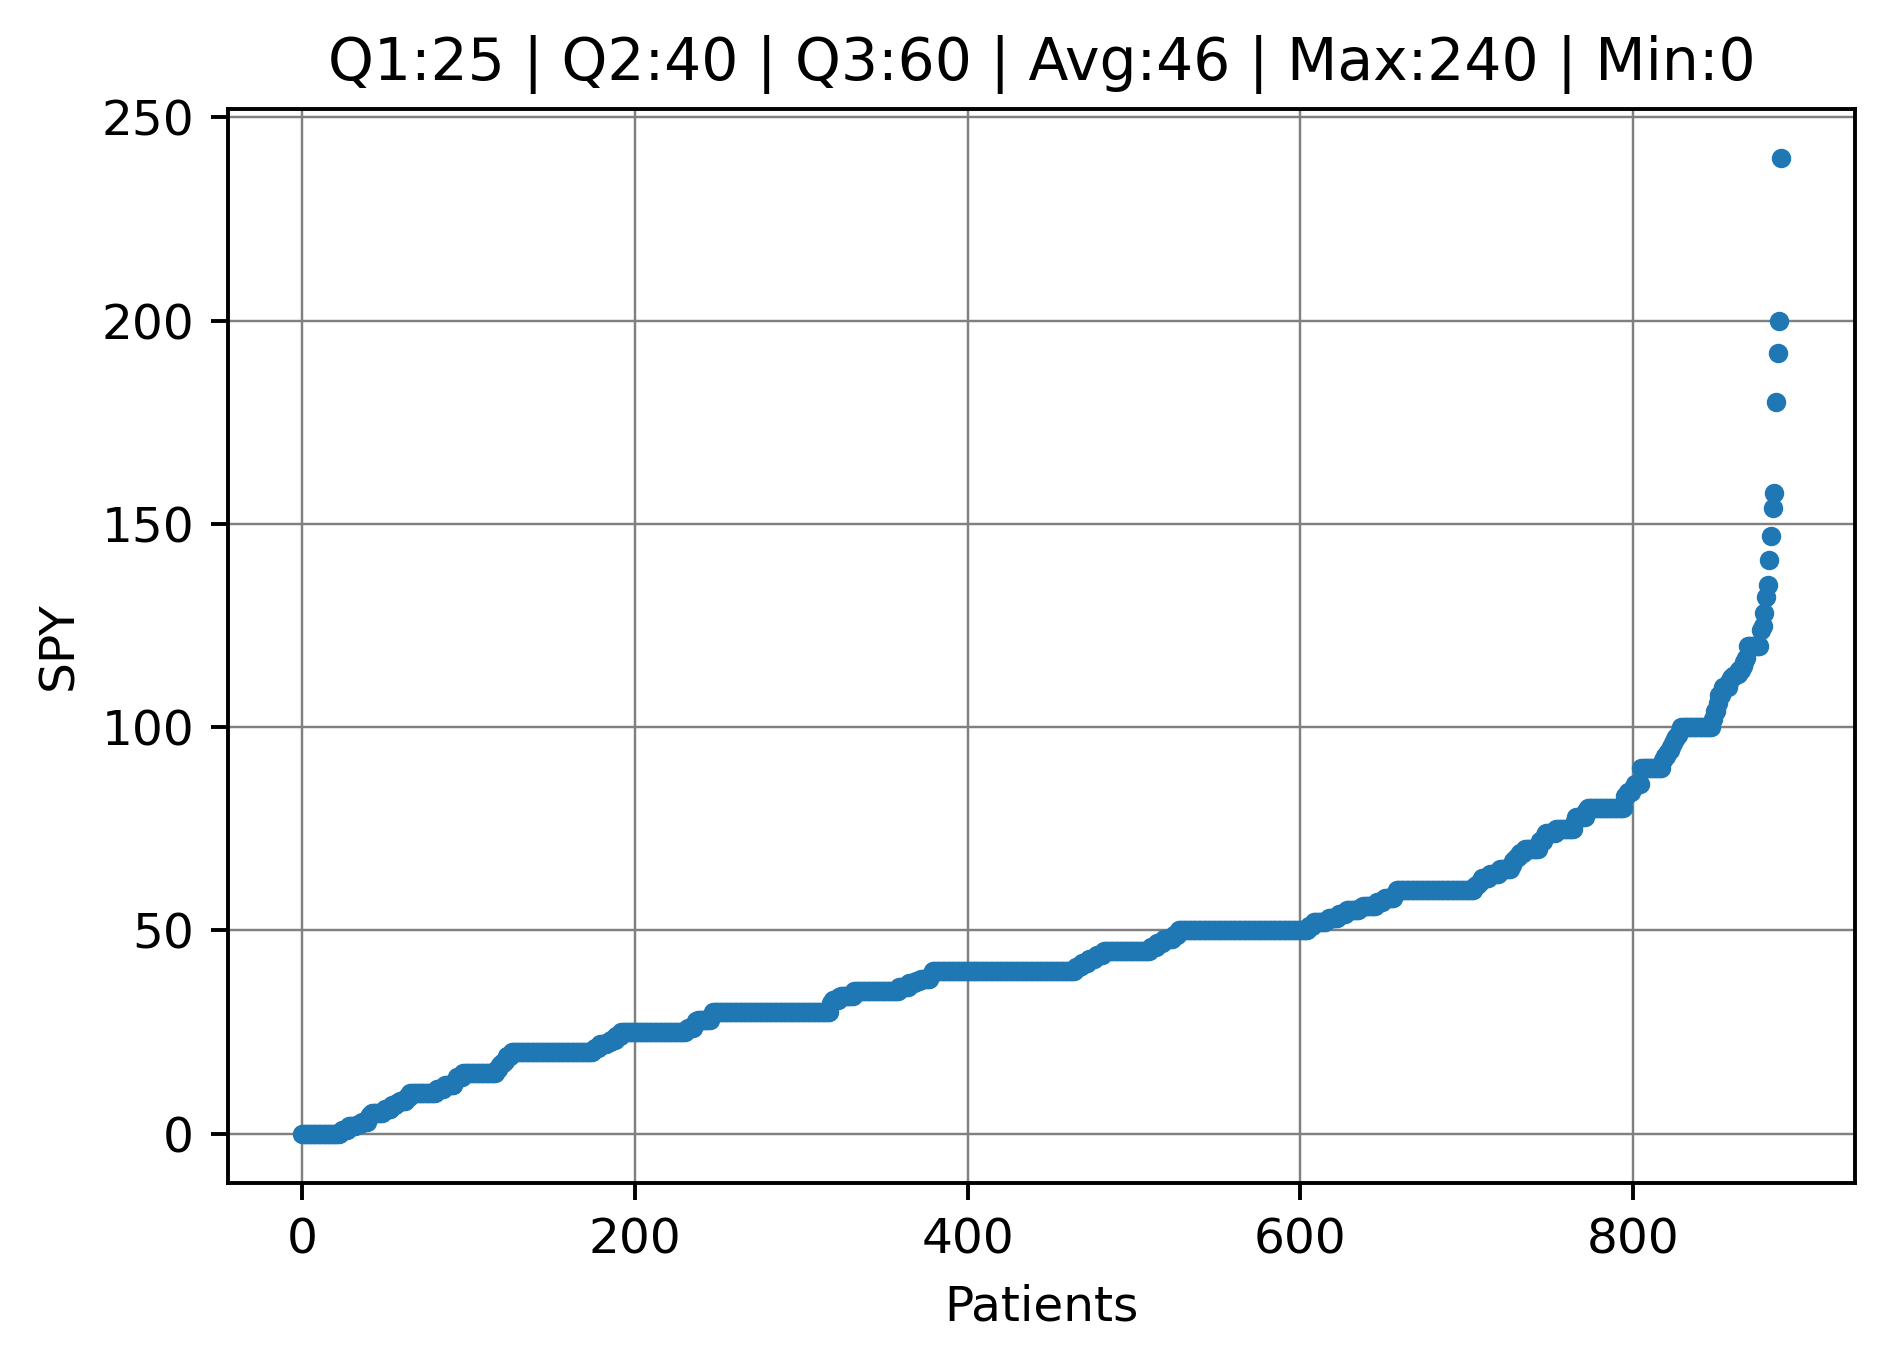

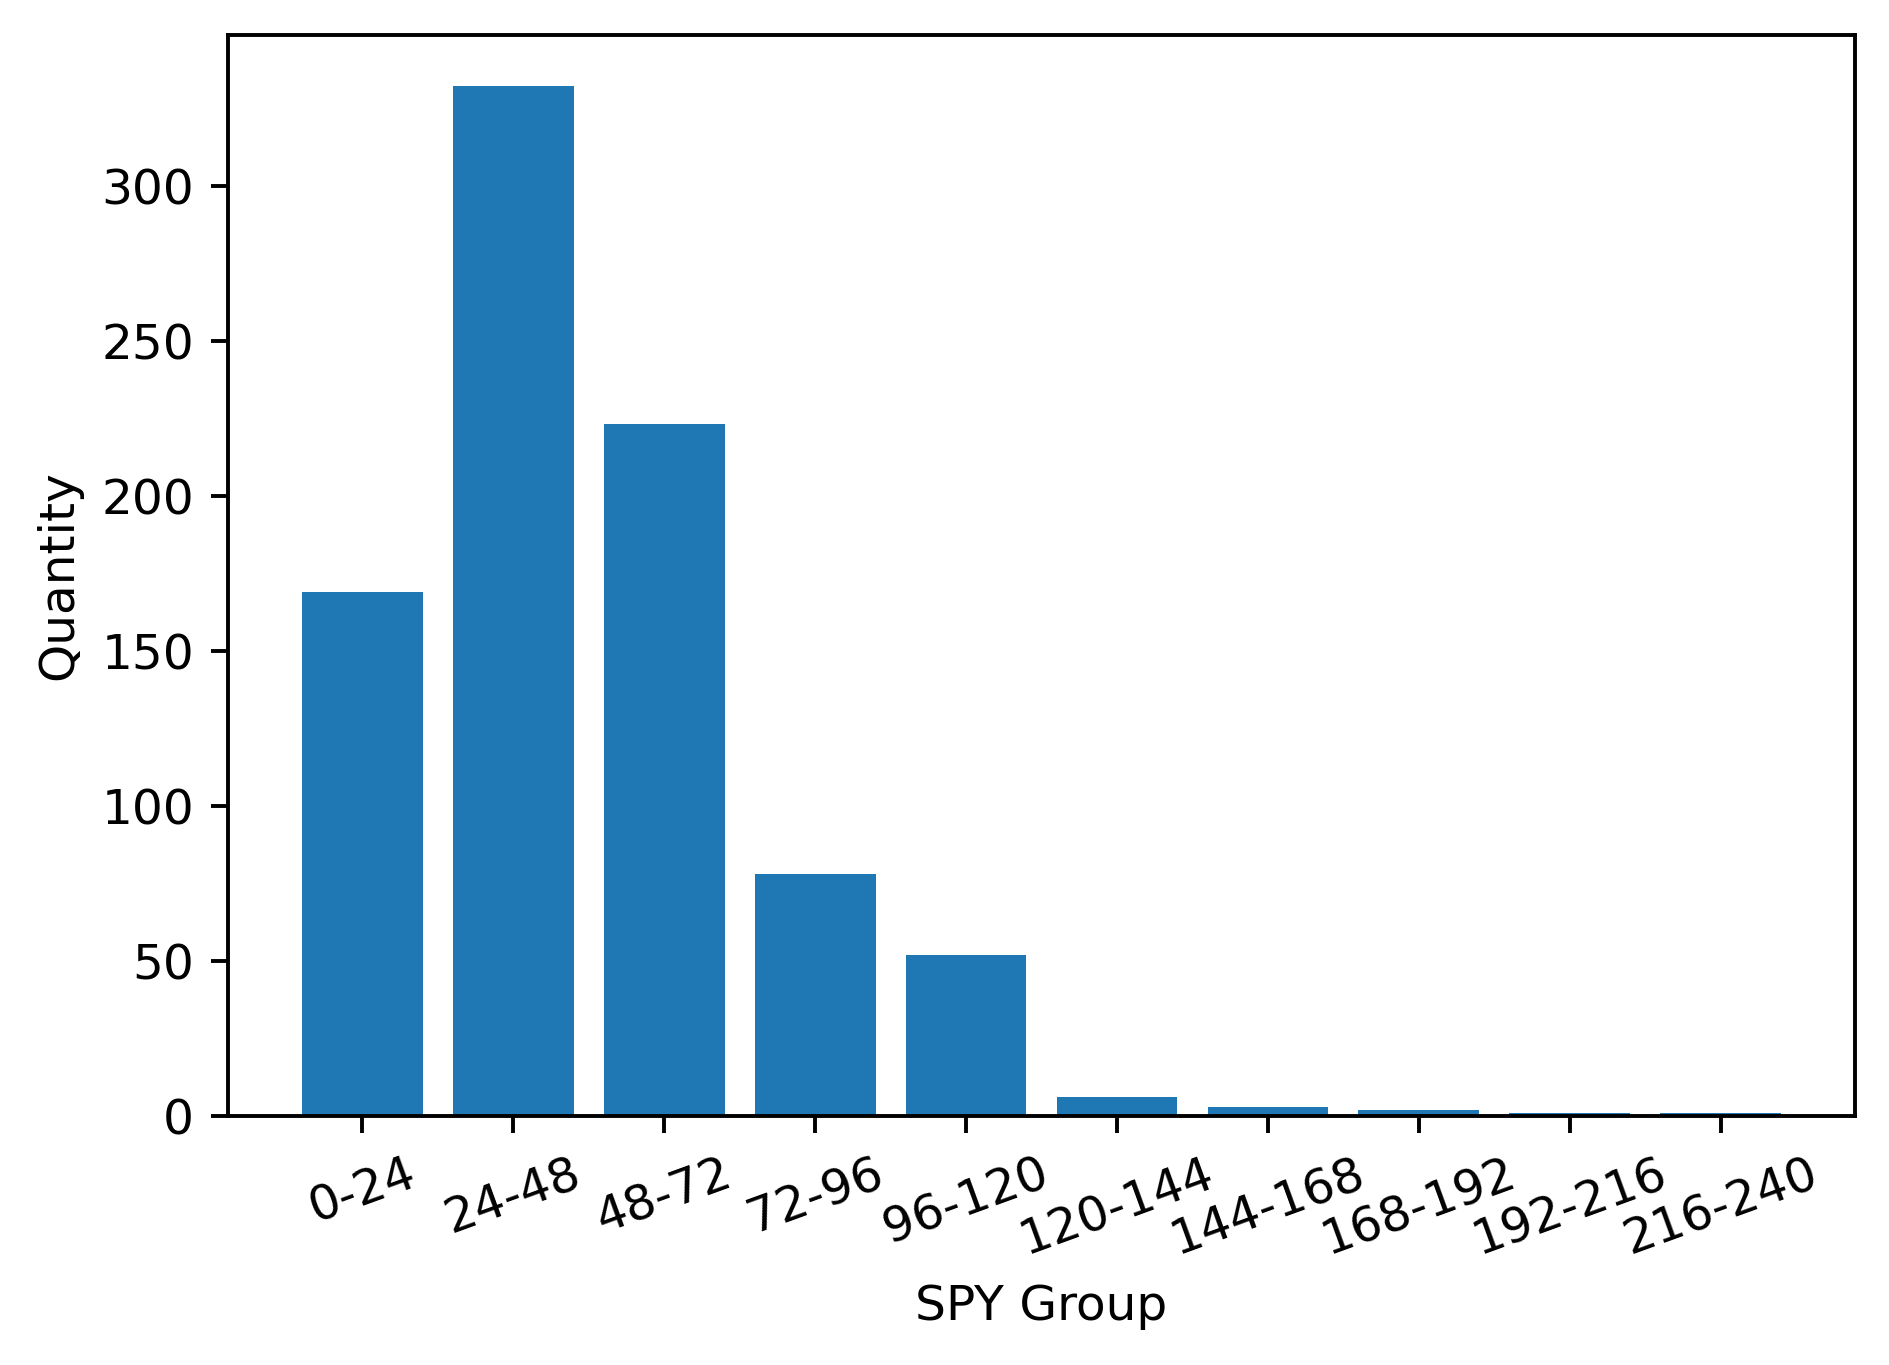

In [13]:
plotDistributionWithInfo(data=sorted(patientDF.SMOKING_PACK_YEARS.dropna()),saveName="smoking pack years",ylabel="SPY",xlabel="Patients")
patientDF["SPY_discrete"]=discretizeIngroups(patientDF.SMOKING_PACK_YEARS,10)
plotHistogram(patientDF.SPY_discrete,"SPY discrete","Quantity","SPY Group")

### Remove SPY outliers

In [14]:
print(patientDF.shape)
patientDF[patientDF.SMOKING_PACK_YEARS<threshold]
data=sorted(patientDF.SMOKING_PACK_YEARS.dropna())
q1 = np.quantile(data, .25)
q2 = np.quantile(data, .50)
q3 = np.quantile(data, .75)
iqr = q3 - q1
threshold = q3 + 2.5*iqr
toDrop = patientDF[patientDF.SMOKING_PACK_YEARS>threshold].index
patientDF=patientDF.drop(toDrop)
print(patientDF.shape)

(1144, 9)
(1138, 9)


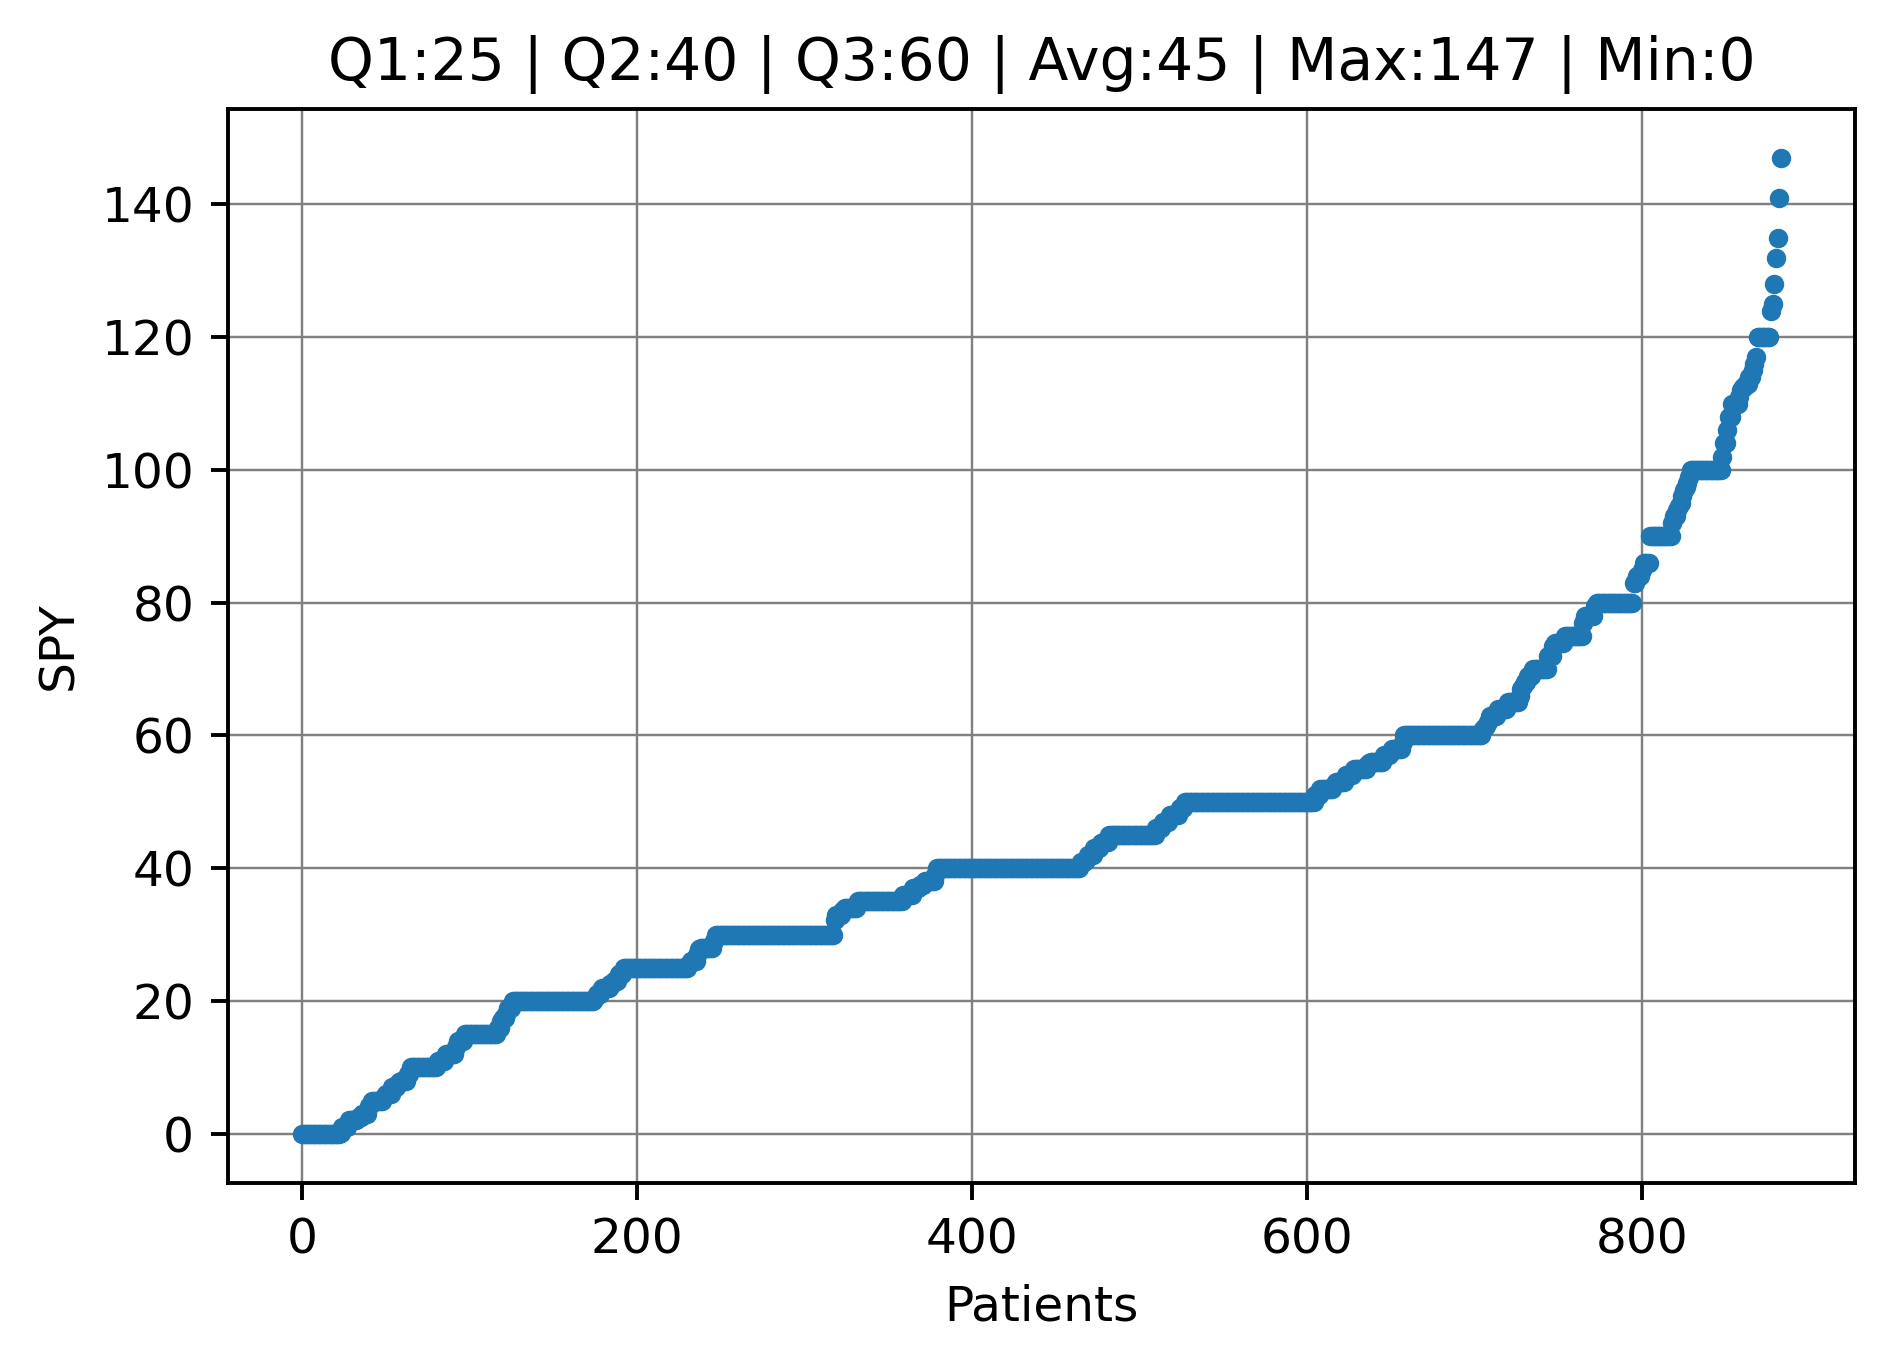

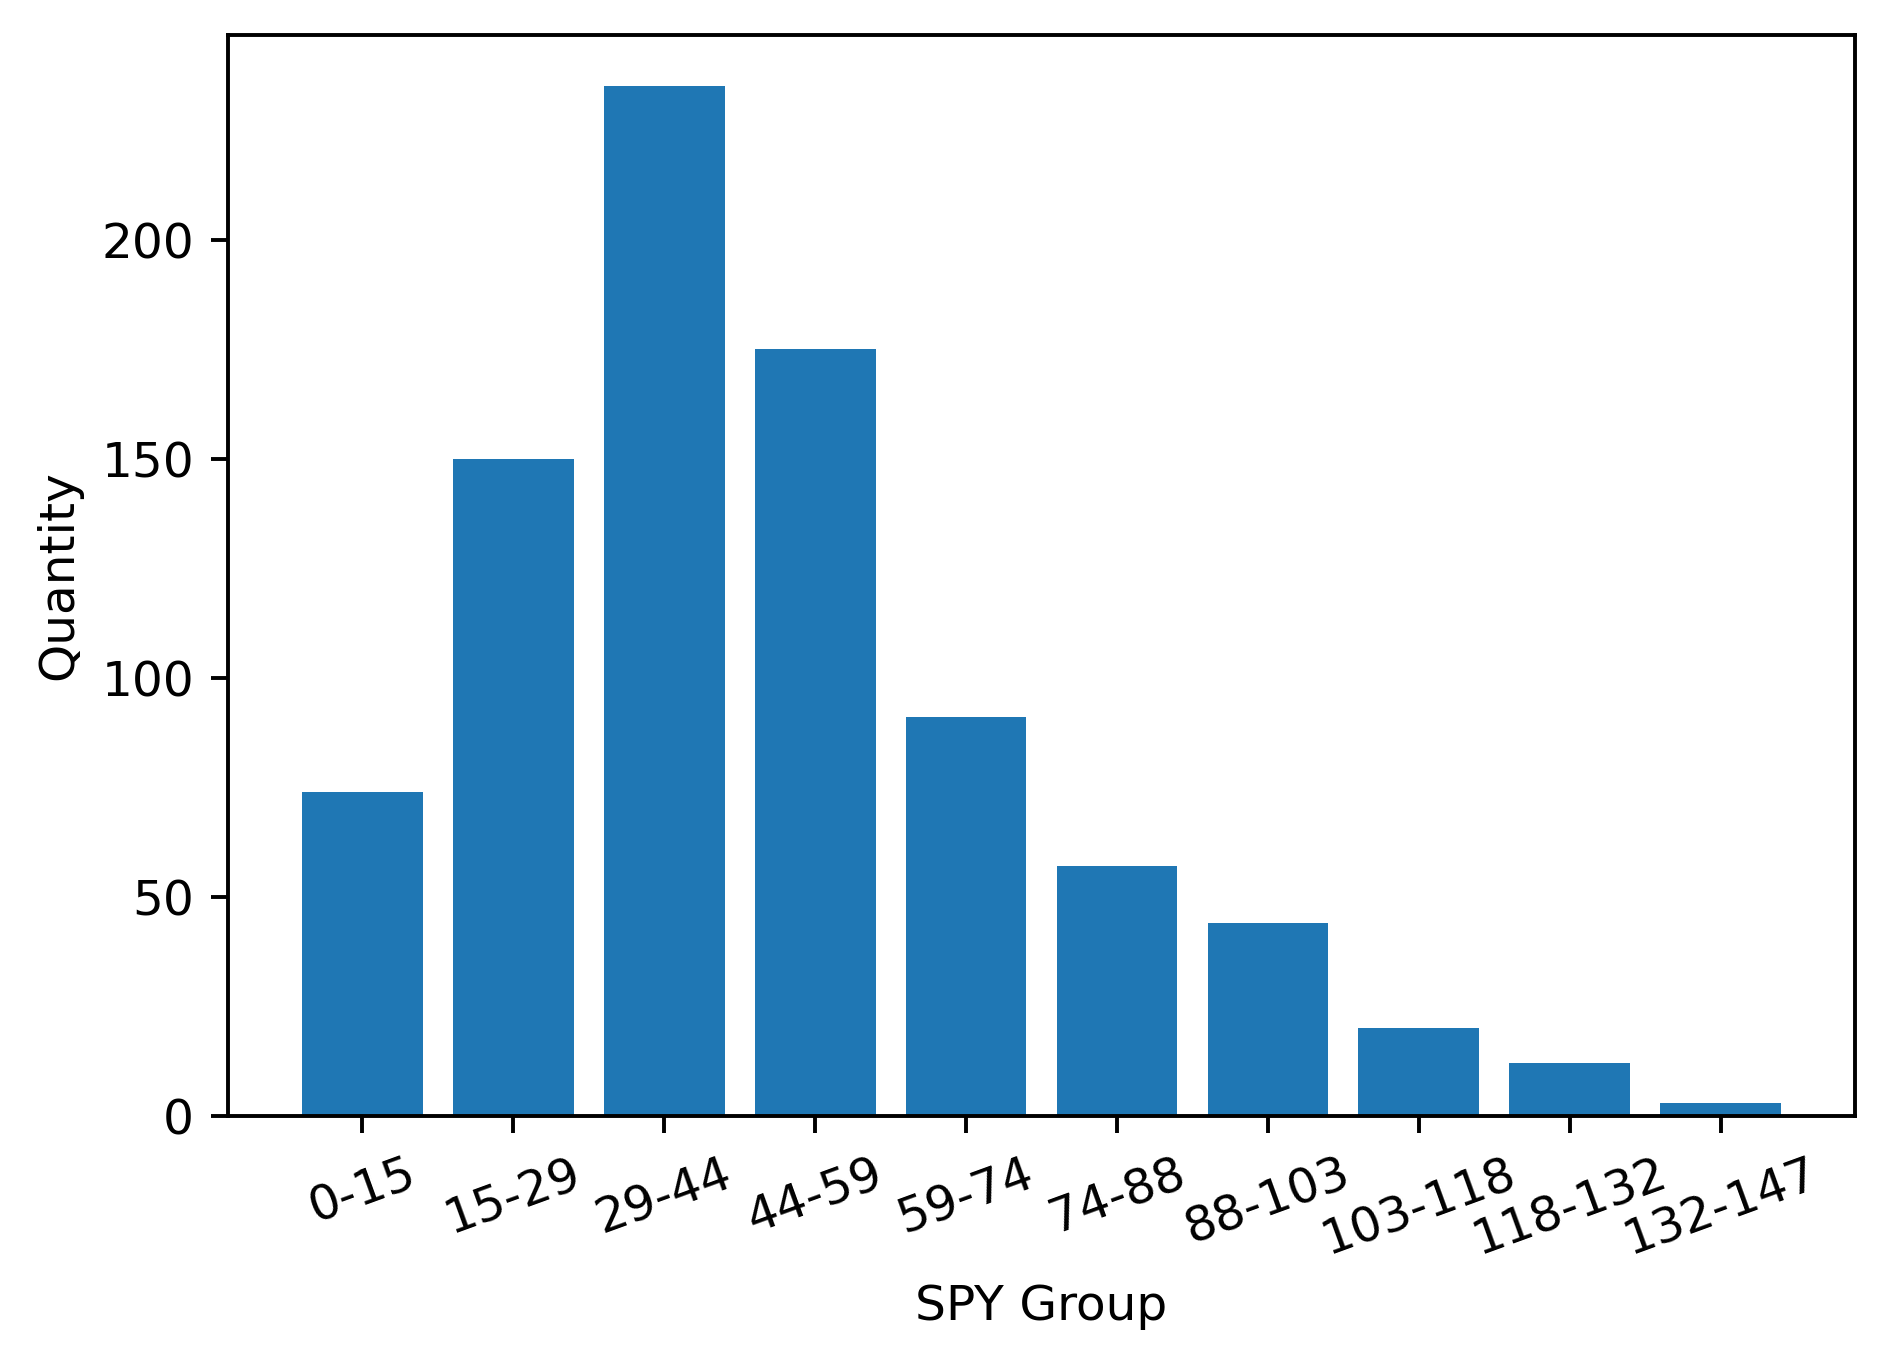

In [15]:
plotDistributionWithInfo(data=sorted(patientDF.SMOKING_PACK_YEARS.dropna()),saveName="smoking pack years - preprocessed",ylabel="SPY",xlabel="Patients")
patientDF["SPY_discrete"]=discretizeIngroups(patientDF.SMOKING_PACK_YEARS,10)
plotHistogram(patientDF.SPY_discrete,"SPY discrete - preprocessed","Quantity","SPY Group")

(1138, 9)


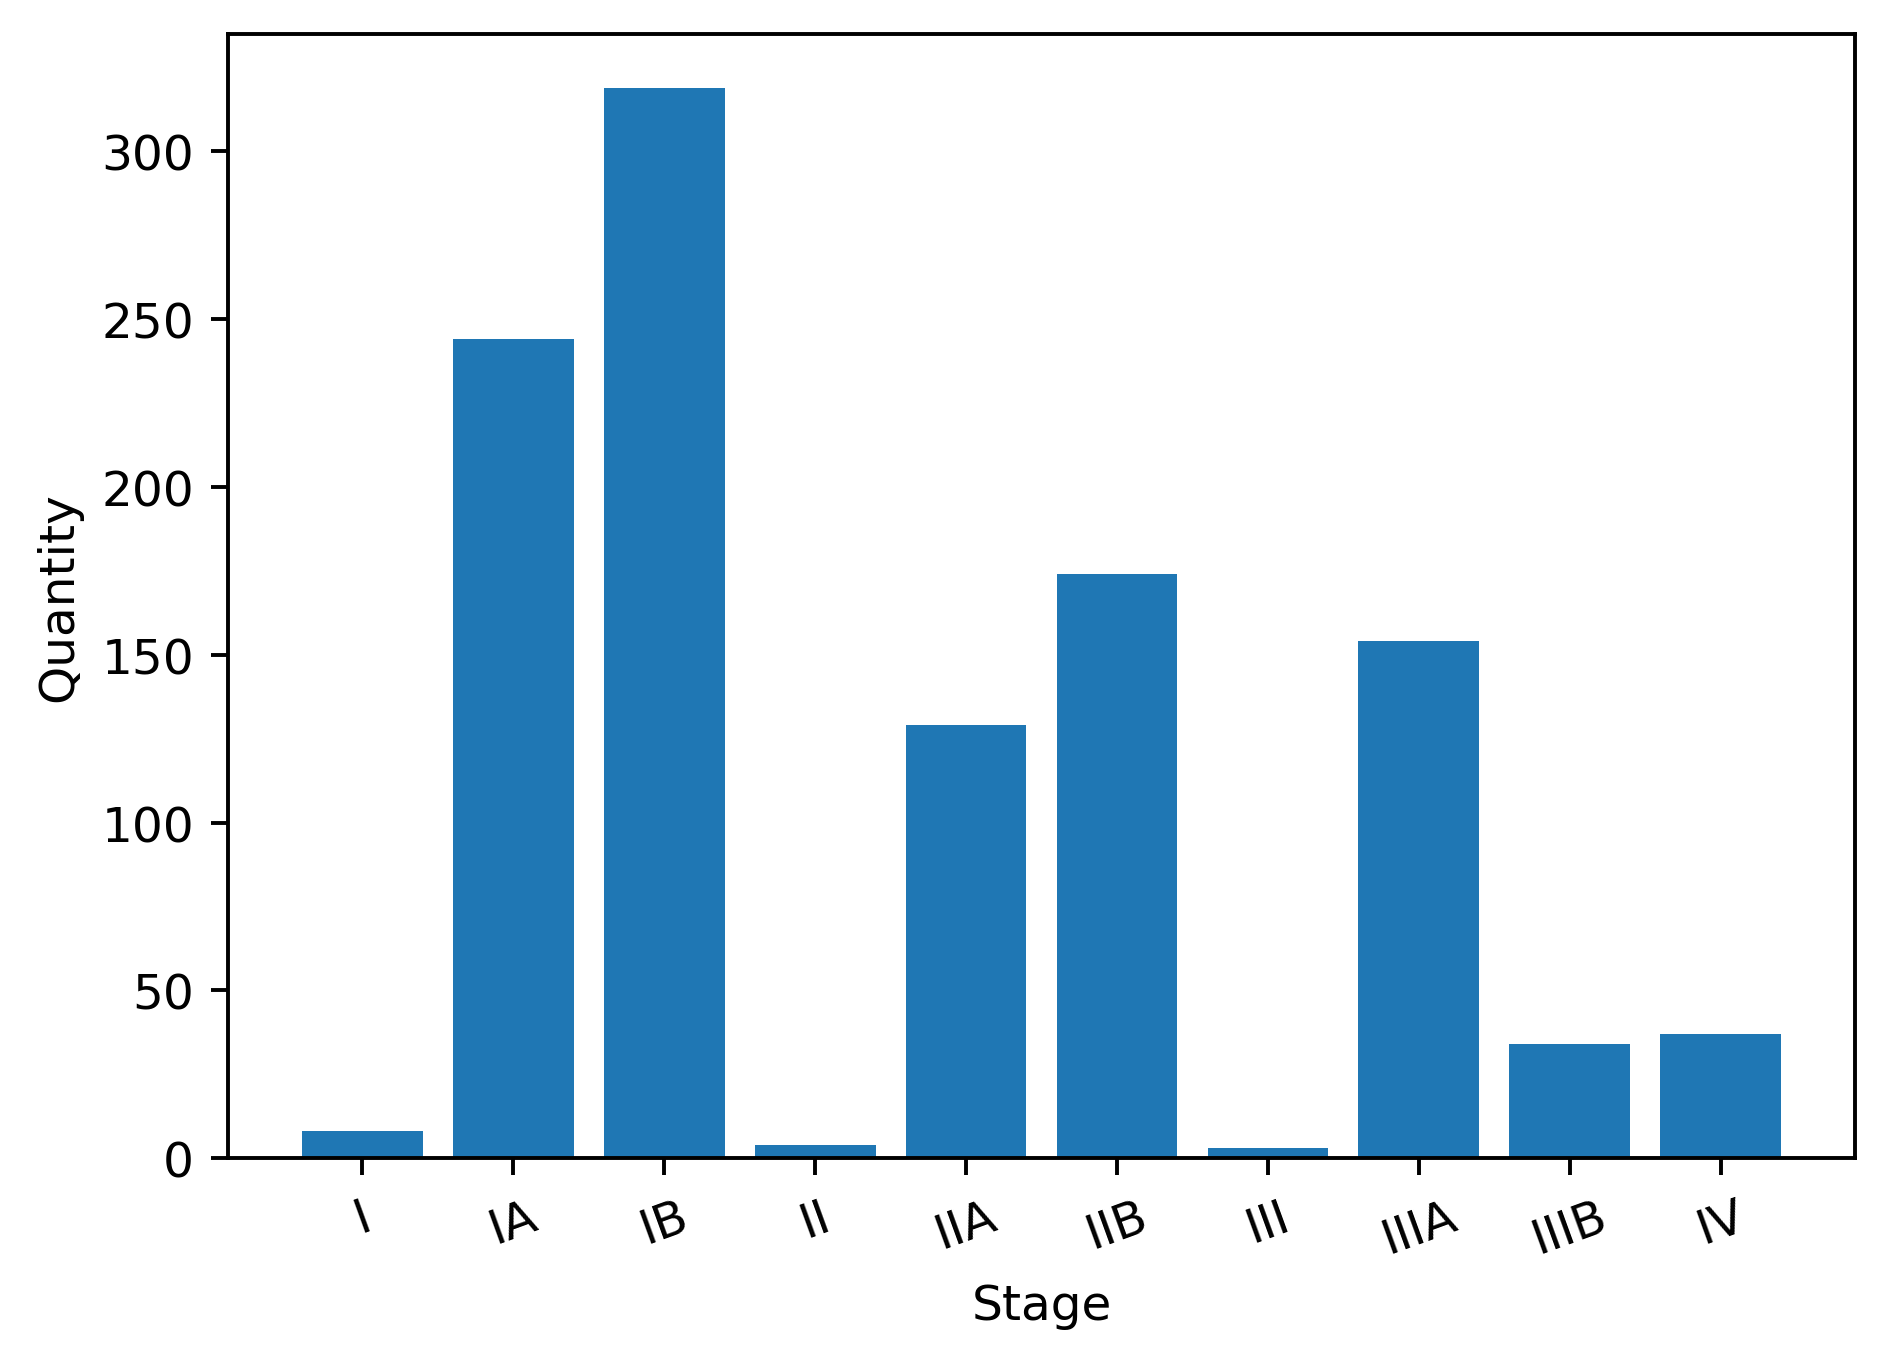

(1123, 9)


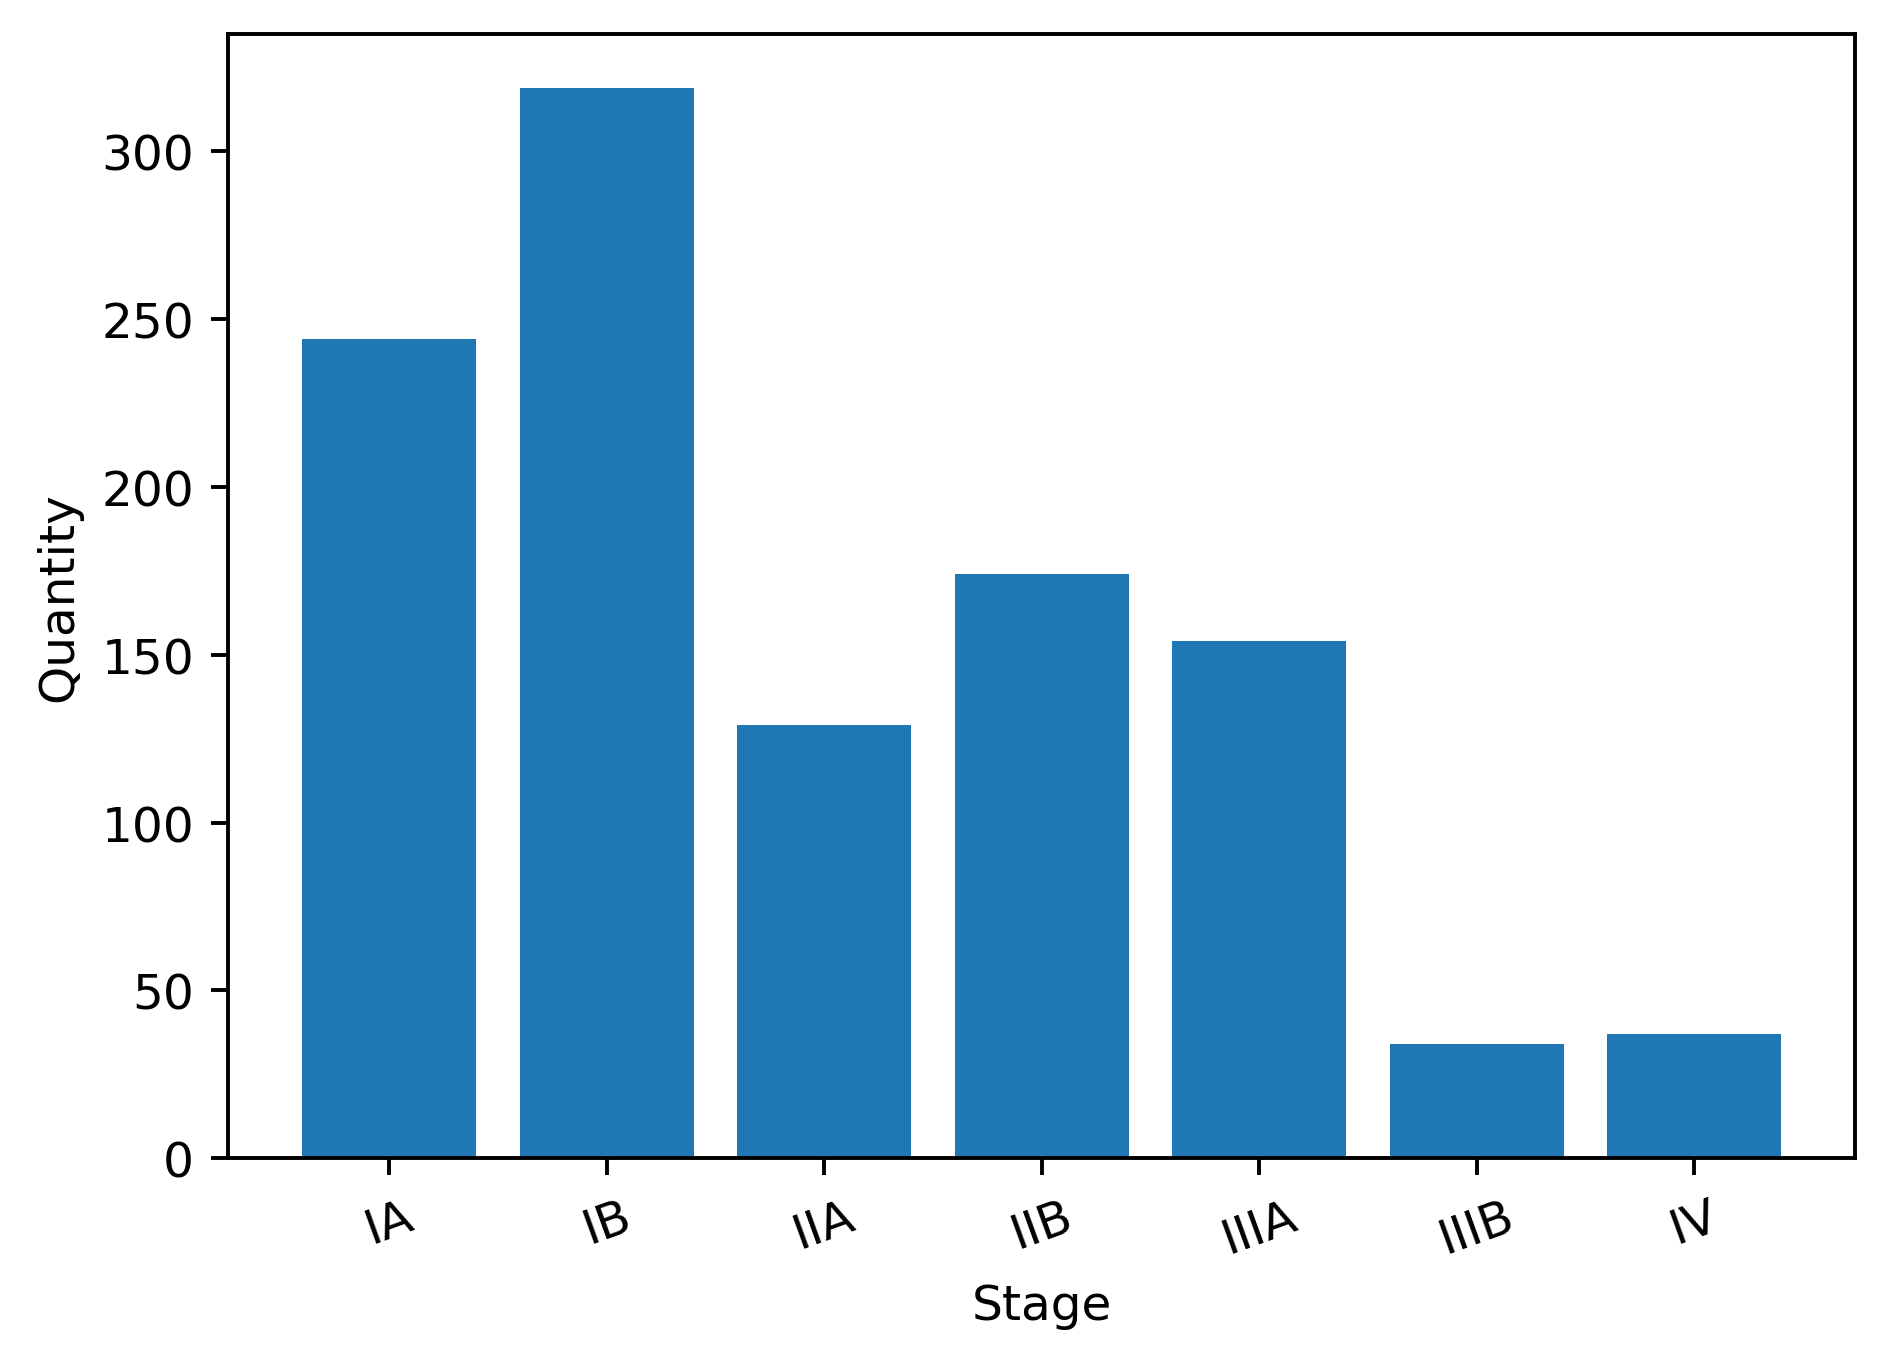

In [16]:
print(patientDF.shape)
plotHistogram(patientDF.STAGE,"StagePatientFile","Quantity","Stage")

toDrop = patientDF[patientDF.STAGE.isin(["I","II","III"])].index
patientDF=patientDF.drop(toDrop)
print(patientDF.shape)
plotHistogram(patientDF.STAGE,"StagePatientFile - Preprocessed","Quantity","Stage")


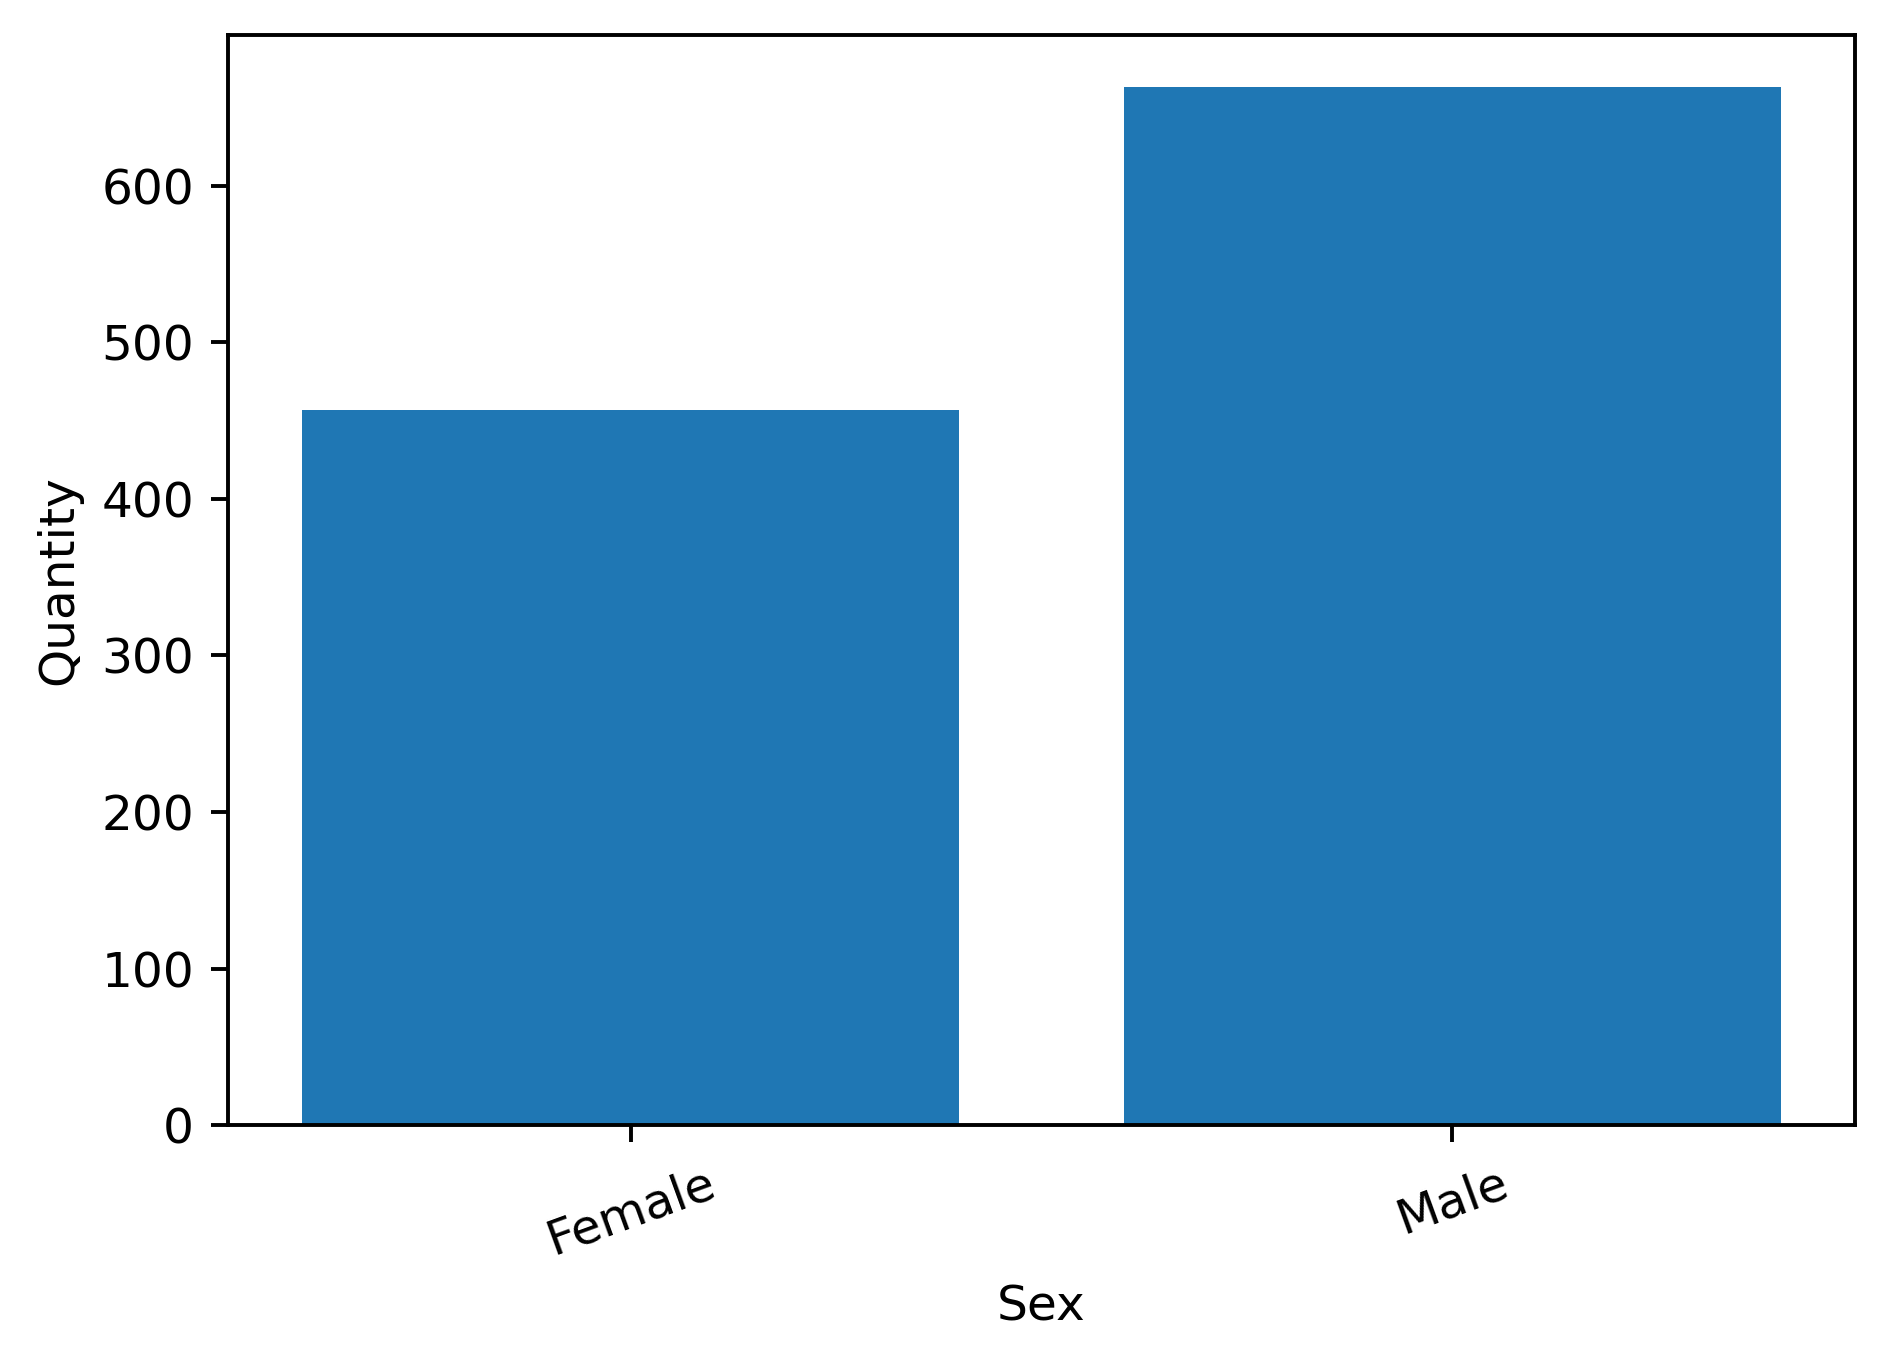

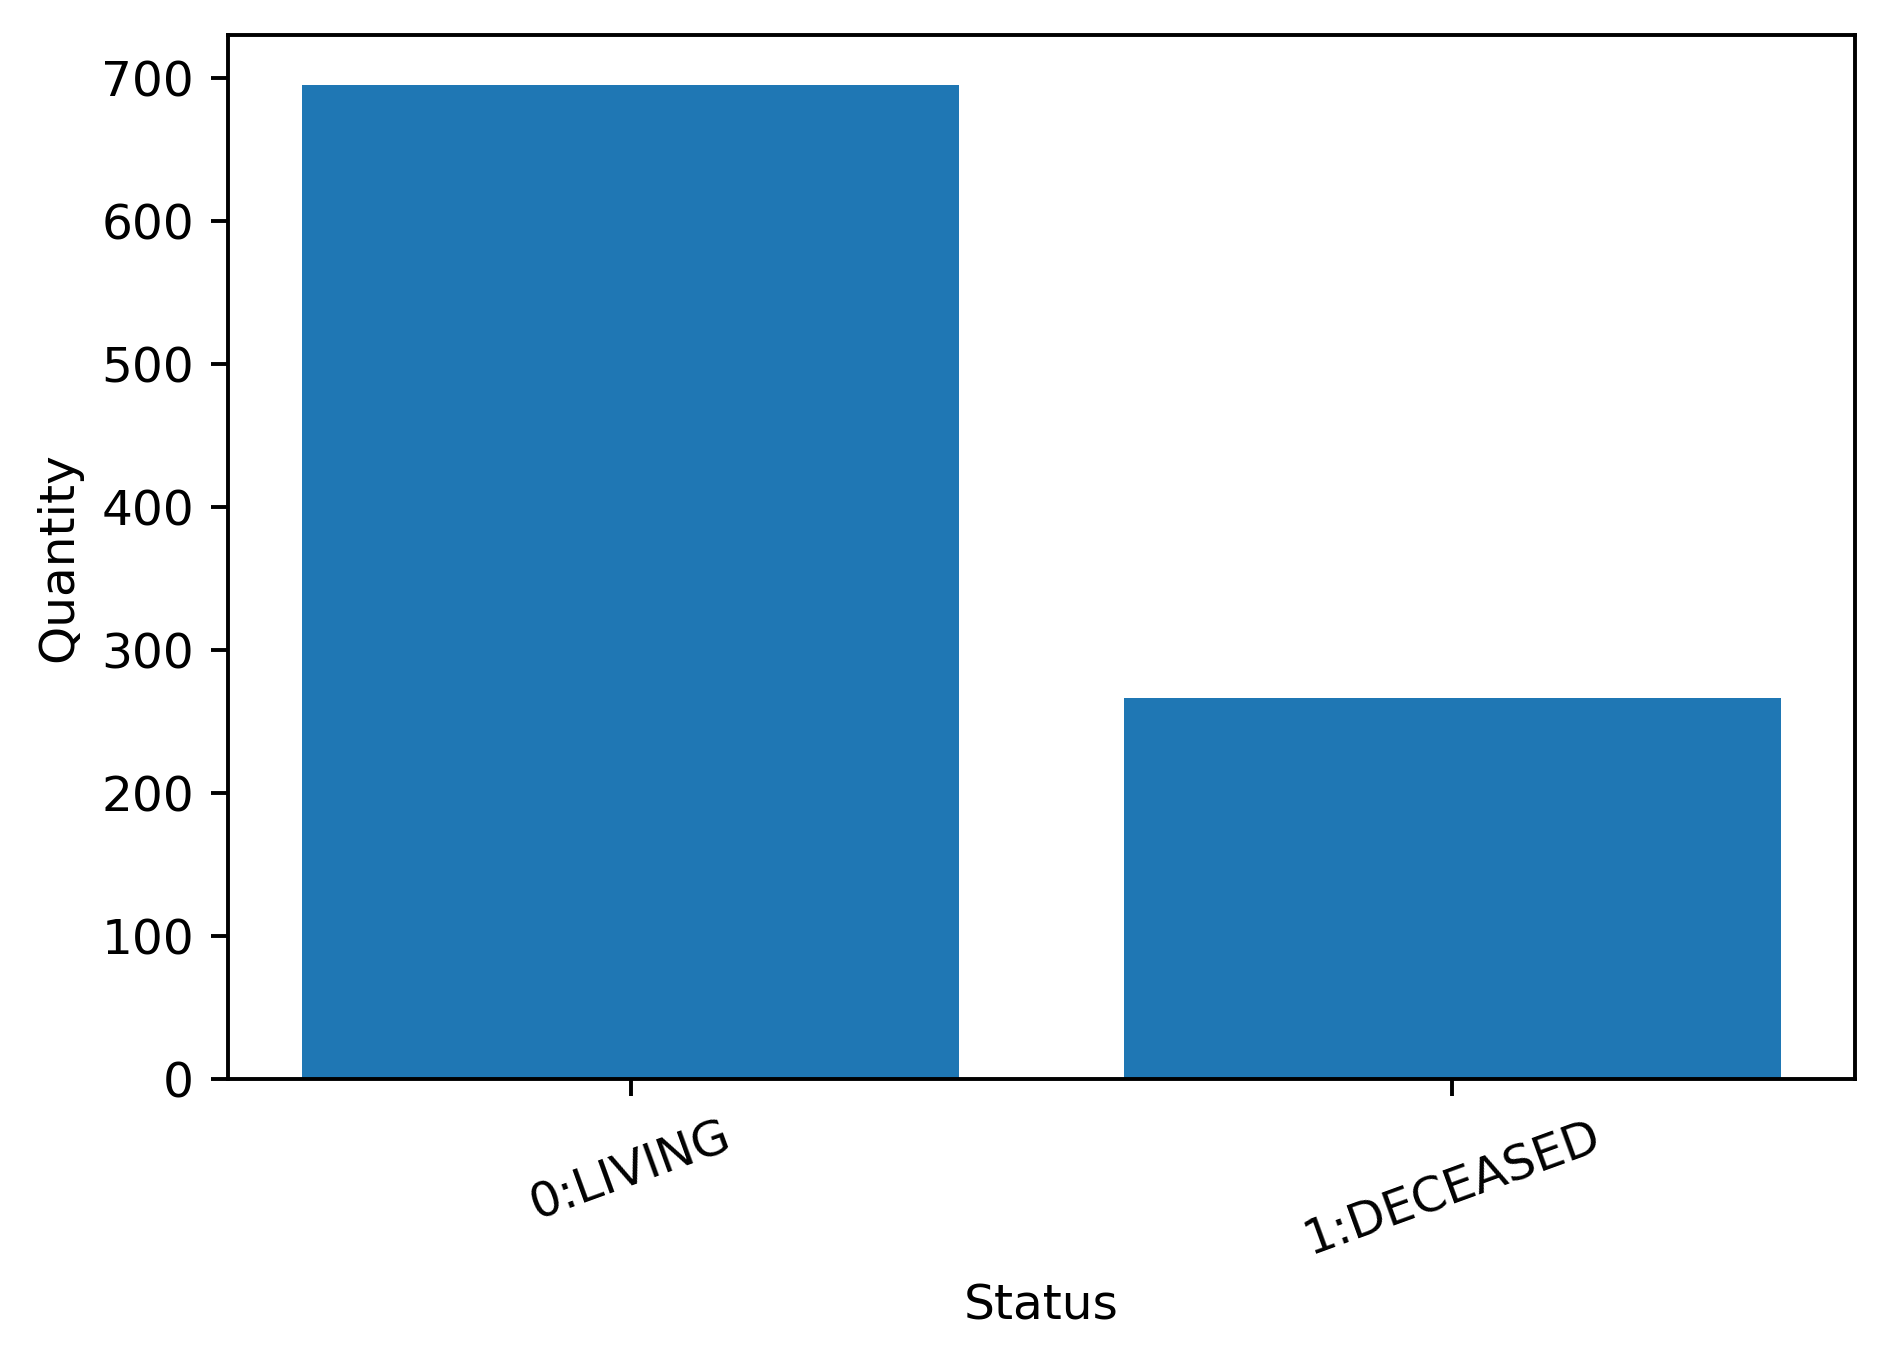

In [17]:
plotHistogram(patientDF.SEX,"Sex","Quantity","Sex")
plotHistogram(patientDF.OS_STATUS,"OsStatus","Quantity","Status")

<hr>

#### 1. Filter the MAF file, removing all Passengers genes and Keeping the drivers

Entire MAF, with passengers and drivers
Number of unique Genes: 17959
Number of Patients: 1144


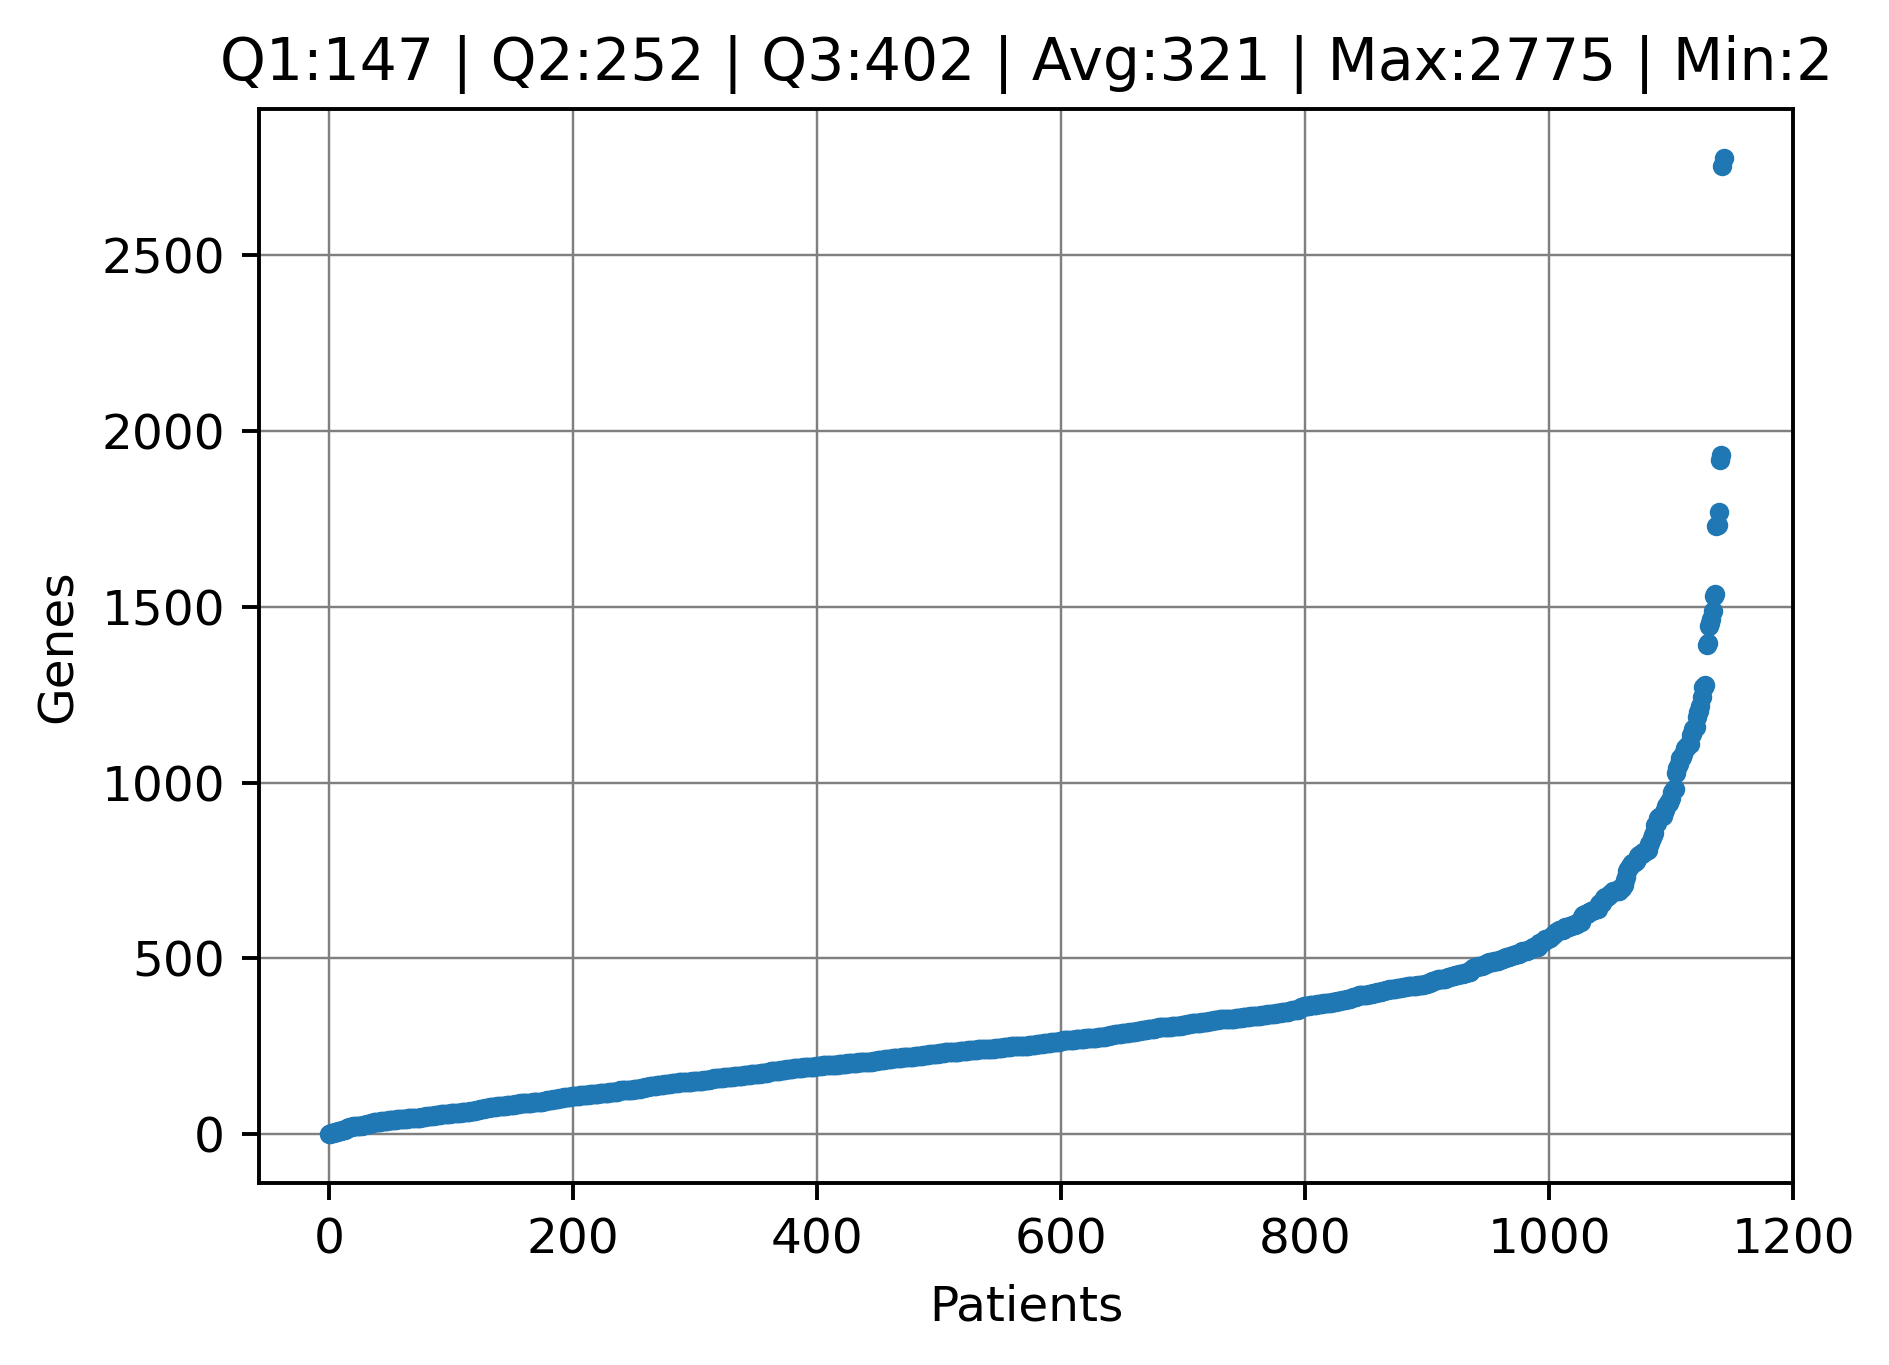

In [18]:
print("Entire MAF, with passengers and drivers")
print("Number of unique Genes: "+str(len(set(MAF.Hugo_Symbol))))
print("Number of Patients: "+str(len(set(MAF.Tumor_Sample_Barcode))))
groupsOfPatients=MAF.groupby(["Tumor_Sample_Barcode"])
genesPerPatient=[]
for id, data in groupsOfPatients:
    genesPerPatient.append(len(set(data.Hugo_Symbol)))
#Sort
genesPerPatient=sorted(genesPerPatient)
plotDistributionWithInfo(genesPerPatient,"Genes per Patient With Passengers and Drivers","Genes","Patients")

In [19]:
MAF_filtered = MAF[MAF.Hugo_Symbol.isin(drivers)]
MAF_filtered = MAF_filtered[["Tumor_Sample_Barcode","Hugo_Symbol"]]

Filtred MAF, with only drivers
Number of unique Genes: 3133
Number of Patients: 1143


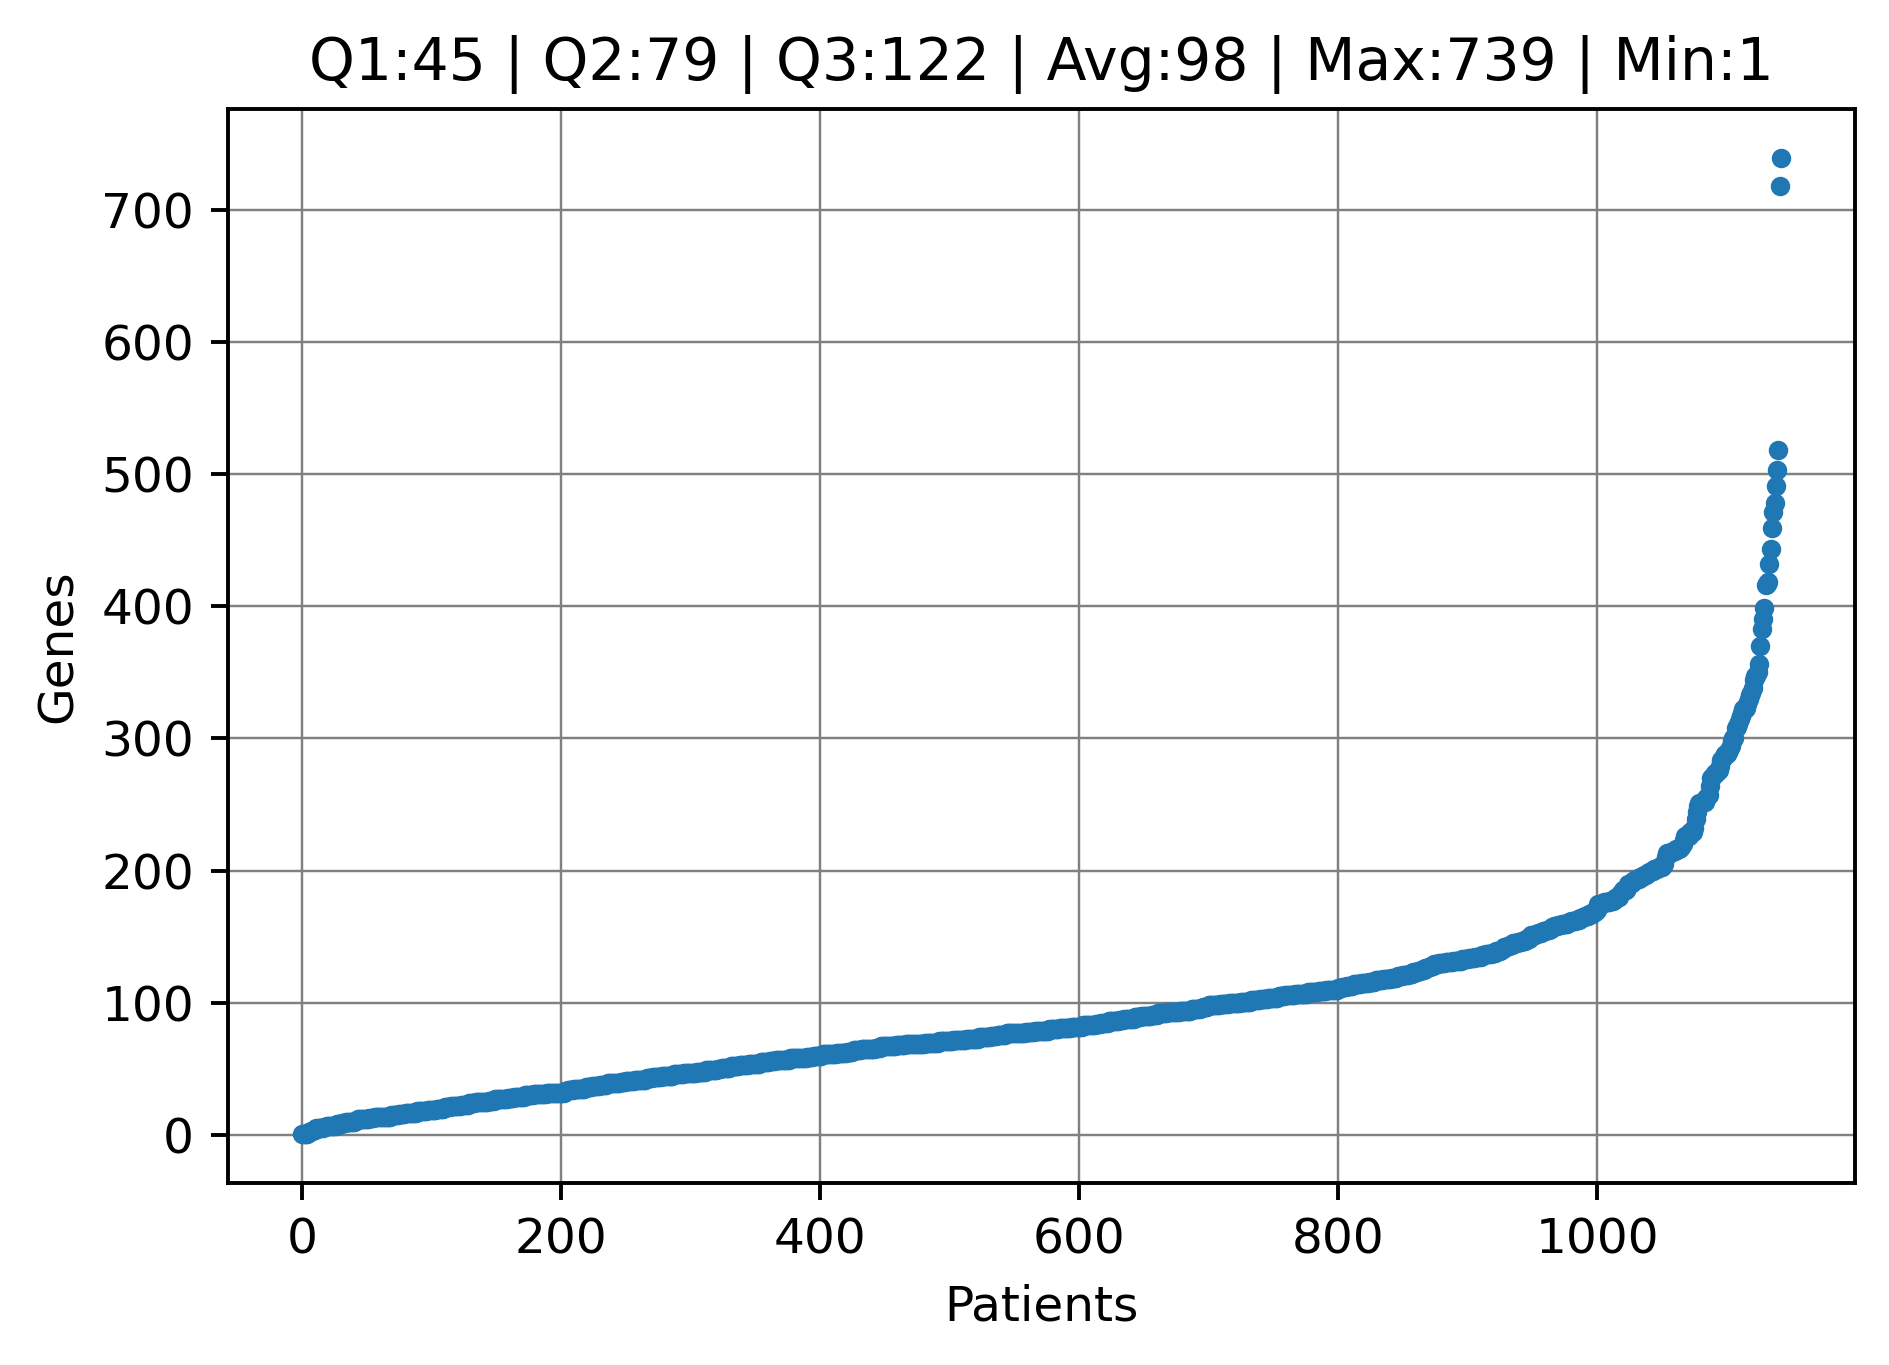

In [20]:
print("Filtred MAF, with only drivers")
print("Number of unique Genes: "+str(len(set(MAF_filtered.Hugo_Symbol))))
print("Number of Patients: "+str(len(set(MAF_filtered.Tumor_Sample_Barcode))))
groupsOfPatients=MAF_filtered.groupby(["Tumor_Sample_Barcode"])
genesPerPatient=[]
for id, data in groupsOfPatients:
    genesPerPatient.append(len(set(data.Hugo_Symbol)))
#Sort
genesPerPatient=sorted(genesPerPatient)
plotDistributionWithInfo(genesPerPatient,"Genes per Patient Without Passengers and With Drivers","Genes","Patients")

The filtered MAF intersect with 94% of the known drivers <br>
We lost 1 patient. From 1144 to 1143 <br>
The AVG and the Q3 is greater than I expected....<br>

<hr>

# Equalize the 3 dataframes
We preprocessed the Sample, Patients and Mutations dataframes. Here we keep the patients in all of them.

In [21]:
print(sampleDF.shape)
print(patientDF.shape)
patientsID = list(set(sampleDF.PATIENT_ID) & set(patientDF.PATIENT_ID))
patientDF=patientDF[patientDF.PATIENT_ID.isin(patientsID)]
sampleDF=sampleDF[sampleDF.PATIENT_ID.isin(patientsID)]
print(sampleDF.shape)
print(patientDF.shape)

(1129, 5)
(1123, 9)
(1108, 5)
(1108, 9)


In [22]:
print(len(set(MAF_filtered.Tumor_Sample_Barcode)))
MAF_filtered=MAF_filtered[MAF_filtered.Tumor_Sample_Barcode.isin(sampleDF.SAMPLE_ID)]
print(len(set(MAF_filtered.Tumor_Sample_Barcode)))

1143
1107


<hr>

#### 2. For each SuperPathway, create a dataframe intersecting the drivers in each patient
#### 3. Include in each dataframe the categorical information about patient and tumour
I am doing step 2 and 3 at the same time. For each SP and For each patient, I check how many drivers it has on the SP, and the categorical data

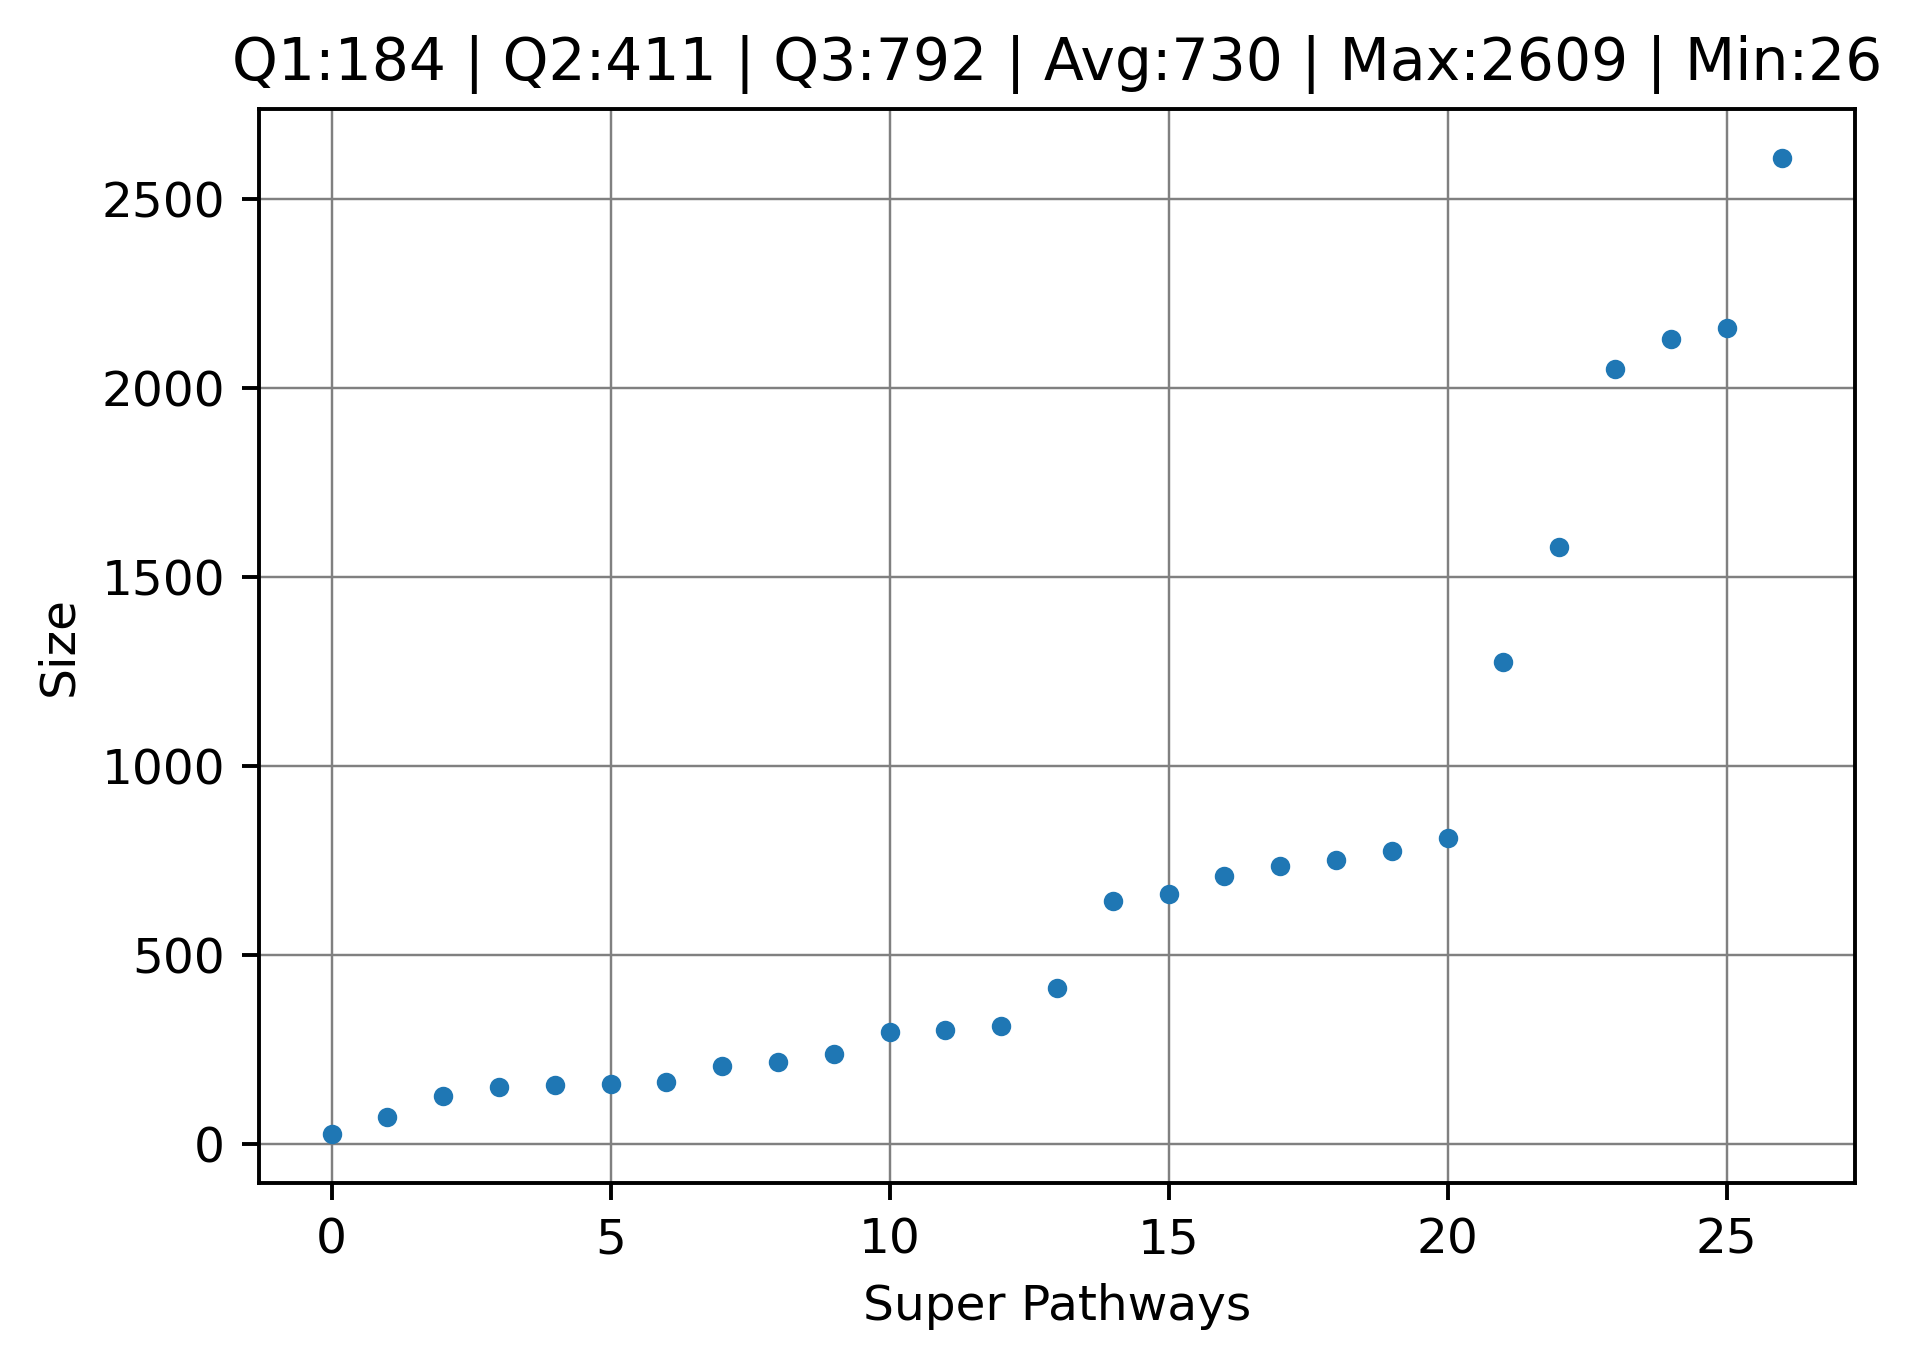

In [23]:
dataSP=sorted([len(genes) for _,genes in superPathways.items()])
plotDistributionWithInfo(dataSP,"Super Pathways Size","Size","Super Pathways")

<hr>

## Create groups of patients using pathways:
For each patient and for each Super Pathway, we test if the intersection between genes is significant. If it is, we add the patient in the pathway group. If the pathway group harbours less than 221 patients (20% of the all patients), we search in the Super Pathway hierarchy for a subpathway that harbours more than 220 patients.

In [18]:
with open("0 - Super Pathways Hierarchy/pathwayGeneSet.pickle", "rb") as file:
    pathwayGeneSet = pickle.load(file)

with open("0 - Super Pathways Hierarchy/pathwayNetworks.pickle", "rb") as file:
    pathwayNetworks = pickle.load(file)

In [22]:
len(pathwayGeneSet["Metabolism"]),len(pathwayGeneSet["Programmed Cell Death"])

(2149, 215)

In [9]:
len(pathwayGeneSet["Programmed Cell Death"]),len(pathwayGeneSet["Apoptosis"]),len(pathwayGeneSet["Regulated Necrosis"])


(215, 181, 61)

In [12]:
pathwayNetworks["Programmed Cell Death"].number_of_nodes()

42

In [25]:
def significantIntersection(A_label,B_label,neither,AnotB,BnotA,both):
    #=== Return Info ===#
    returnDict={}
    returnDict['A']=A_label
    returnDict['B']=B_label
    returnDict['Neither']=neither
    returnDict['AnotB']=AnotB
    returnDict['BnotA']=BnotA
    returnDict['Both']=both
    returnDict['EBC'] = ''
    
    #=== Odds Ratio #
    #We are using two-sided, cbioportal is also using it: https://docs.cbioportal.org/news/#aug-1-2023
    oddsratio,pFisher = stats.fisher_exact([[both, AnotB], [BnotA, neither]],alternative='two-sided')
    #oddsratio = round((neither * both) / (AnotB * BnotA),3)
    returnDict['OR'] = oddsratio
    returnDict['OR log2'] = np.log2(oddsratio) if oddsratio > 0 else 0
    returnDict['pValue']=round(pFisher,3)
    
    #=== Return Info ===#
    total=neither+AnotB+BnotA+both
    if(total<=0):
        return None       
    else:
        pA = (AnotB+both)/total
        pB = (BnotA+both)/total
        expectedByChance=pA*pB*total
#         returnDict['pA']=round(pA,2)
#         returnDict['pB']=round(pB,2)
        returnDict['EBC']=int(expectedByChance)

        return returnDict

In [26]:
#Background Genes are used to calculate the pvalue between genes and pathways
backgroundGenes=set(MAF.Hugo_Symbol)
print(len(backgroundGenes))


17959


In [27]:
numberOfPatients = len(set(MAF_filtered.Tumor_Sample_Barcode))
round(numberOfPatients * 0.2)

221

The code bellow took 98 minutes to complete in the desktop and 169 on the laptop

In [29]:
#%%time
#The next 3 variables are just to collect "Meta Data" about the procedure and to help understanding the outcome
groupResume={}
patientVSPathways={}
cont=1

spSolved=[]

#if the super pathway intersection with patients is not enought, we check the subpathways
#This is the reason why is split the names
pathwaysList=sorted(list(superPathwaysNames))
# pathwaysList=["Autophagy"]
for name in pathwaysList:
    isIntersectionSignificant = False
    names = name.split(" -- ")
    spName = names[0]
    print("Iteration: ",cont," | Total:",len(pathwaysList))
    cont+=1
    #No need to search for a subpathway if the intersection with this SP (or any other child) is solved
    if spName in spSolved:
        continue
    print("")
    print(name)
    
    if len(names)>1:
        subName=names[1]
    else:
        subName=""

    if subName=="":
        genes = pathwayGeneSet[spName]
    else:
        if subName in pathwayGeneSet:
            genes = pathwayGeneSet[subName]
        else:
            #not all subpathways have a gene list associated (but the vast majority (>95%) has). This is a problem with the data from Reactome. To 
            continue

    patientVSPathways[name]={}
    groupResume[name]={
        "SP len":len(genes),
        "Patients":0,
        "Patients %":0,
        "Ratio Pat/len":0
    }
    dataFrame={}
    dataFrame["PatientID"]=[]
    #patient data
    dataFrame["Age"]=[]
    dataFrame["Age_Discrete"]=[]
    dataFrame["Sex"]=[]
    dataFrame["Smoking"]=[]
    dataFrame["SPY"]=[]
    dataFrame["SPY_Discrete"]=[]
    dataFrame["Stage"]=[]
    dataFrame["Status"]=[]
    #tumor data
    dataFrame["TMB"]=[]
    dataFrame["TMB_Discrete"]=[]
    dataFrame["Tstage"]=[]
    #pathway intersection
    dataFrame[name]=[]
    for sampleID, df in MAF_filtered.groupby("Tumor_Sample_Barcode"):
        #only fill the df id the intersection is meaningful
        if subName=="":
            genesPathway = set(pathwayGeneSet[spName])
        else:
            genesPathway = set(pathwayGeneSet[subName])

        genesSamples = set(MAF_filtered[MAF_filtered.Tumor_Sample_Barcode == sampleID].Hugo_Symbol)

        neither = len(backgroundGenes-genesSamples-genesPathway)
        AnotB = len(genesSamples-genesPathway)
        BnotA = len(genesPathway-genesSamples)
        both = len(genesSamples&genesPathway)

        result = significantIntersection(A_label=sampleID,B_label=name,neither=neither,AnotB=AnotB,BnotA=BnotA,both=both)
        if result["pValue"]<0.05 and result["OR"]>1:

            #Sample/Tumor data
            dataFrame["Tstage"].append(sampleDF[sampleDF.SAMPLE_ID == sampleID].T_STAGE.values[0])
            dataFrame["TMB"].append(sampleDF[sampleDF.SAMPLE_ID == sampleID].TMB.values[0])
            dataFrame["TMB_Discrete"].append(sampleDF[sampleDF.SAMPLE_ID == sampleID].TMB_discrete.values[0])
            patientID = sampleDF[sampleDF.SAMPLE_ID == sampleID].PATIENT_ID.values[0]
            dataFrame["PatientID"].append(patientID)

            #Patient Data
            dataFrame["Age"].append(patientDF[patientDF.PATIENT_ID == patientID].AGE.values[0])
            dataFrame["Age_Discrete"].append(patientDF[patientDF.PATIENT_ID == patientID].AGE_discrete.values[0])
            dataFrame["Sex"].append(patientDF[patientDF.PATIENT_ID == patientID].SEX.values[0])
            dataFrame["Smoking"].append(patientDF[patientDF.PATIENT_ID == patientID].SMOKING_HISTORY.values[0])
            dataFrame["SPY"].append(patientDF[patientDF.PATIENT_ID == patientID].SMOKING_PACK_YEARS.values[0])
            dataFrame["SPY_Discrete"].append(patientDF[patientDF.PATIENT_ID == patientID].SPY_discrete.values[0])
            dataFrame["Stage"].append(patientDF[patientDF.PATIENT_ID == patientID].STAGE.values[0])
            dataFrame["Status"].append(patientDF[patientDF.PATIENT_ID == patientID].OS_STATUS.values[0])

            #Intersection between SP genes and Driver in the current patient
            value=len(set(df.Hugo_Symbol)&set(genes))

            patientVSPathways[name][patientID]=value

            dataFrame[name].append(value)
            if value > 0 :
                groupResume[name]["Patients"]+=1

    if groupResume[name]['Patients']>=round(numberOfPatients * 0.2):
        isIntersectionSignificant = True
        spSolved.append(spName)
    else:
        G=pathwayNetworks[spName]
        if subName=="":
            children = list(G.neighbors(spName))
        else:
            children = list(G.neighbors(subName))
            
        for child in children:
            if spName+" -- "+child not in pathwaysList:
                pathwaysList.append(spName+" -- "+child)
    
    print("Number of Patients intersected: ",groupResume[name]['Patients'], " | OR:",result["OR"] )
    if(isIntersectionSignificant):
        print("==SAVING==")

        groupResume[name]["Patients %"]=round(
                groupResume[name]["Patients"]/patientDF.shape[0]*100,3
            )
        
        groupResume[name]["Ratio Pat/len"]=round(
            groupResume[name]["Patients"]/groupResume[name]["SP len"],3
            )
        pd.DataFrame(dataFrame).to_csv("1 - Output/datasets/"+name+".csv",sep="\t",index=False)
    else:
        print("==DEEPING THE SEARCH==")
    # if cont ==5:
    #     break
    

Iteration:  1  | Total: 27

Autophagy
Number of Patients intersected:  13  | OR: 0.0
==DEEPING THE SEARCH==
Iteration:  2  | Total: 30

Cell Cycle
Number of Patients intersected:  170  | OR: 2.474570610687023
==DEEPING THE SEARCH==
Iteration:  3  | Total: 34

Cell-Cell communication
Number of Patients intersected:  339  | OR: 0.0
==SAVING==
Iteration:  4  | Total: 34

Cellular responses to stimuli
Number of Patients intersected:  58  | OR: 1.2938829286655373
==DEEPING THE SEARCH==
Iteration:  5  | Total: 36

Chromatin organization
Number of Patients intersected:  195  | OR: 2.2047607178464608
==DEEPING THE SEARCH==
Iteration:  6  | Total: 37

Circadian Clock
Number of Patients intersected:  51  | OR: 0.0
==DEEPING THE SEARCH==
Iteration:  7  | Total: 40

DNA Repair
Number of Patients intersected:  120  | OR: 1.6715370018975333
==DEEPING THE SEARCH==
Iteration:  8  | Total: 47

DNA Replication
Number of Patients intersected:  1  | OR: 0.0
==DEEPING THE SEARCH==
Iteration:  9  | Total: 4

### Relationship between Pathway and Patient

In [ ]:
patientVSPathways = pd.DataFrame(patientVSPathways)
patientVSPathways

,Autophagy,Cell Cycle,Cell-Cell communication,Cellular responses to stimuli,Chromatin organization,Circadian Clock,DNA Repair,DNA Replication,Developmental Biology,Digestion and absorption,...,Cell Cycle -- Polymerase switching,Cell Cycle -- Processive synthesis on the lagging strand,Cell Cycle -- Autodegradation of the E3 ubiquitin ligase COP1,Cell Cycle -- Removal of the Flap Intermediate from the C-strand,DNA Repair -- Resolution of D-loop Structures through Synthesis-Dependent Strand Annealing (SDSA),DNA Repair -- Resolution of D-loop Structures through Holliday Junction Intermediates,DNA Repair -- Presynaptic phase of homologous DNA pairing and strand exchange,Cell Cycle -- Cdc20:Phospho-APC/C mediated degradation of Cyclin A,Cell Cycle -- APC-Cdc20 mediated degradation of Nek2A,Cell Cycle -- Removal of the Flap Intermediate
LUAD-NYU689,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LUAD-S01405,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-34-5239,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-39-5019,3.0,5.0,NaN,NaN,NaN,NaN,3.0,NaN,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-49-4486,3.0,9.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-85-A4PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LUAD-S01320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-90-7767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-98-A53C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
patientVSPathways.count()

Autophagy                                                                                 13
Cell Cycle                                                                               170
Cell-Cell communication                                                                  339
Cellular responses to stimuli                                                             58
Chromatin organization                                                                   195
                                                                                        ... 
DNA Repair -- Resolution of D-loop Structures through Holliday Junction Intermediates     63
DNA Repair -- Presynaptic phase of homologous DNA pairing and strand exchange             57
Cell Cycle -- Cdc20:Phospho-APC/C mediated degradation of Cyclin A                         2
Cell Cycle -- APC-Cdc20 mediated degradation of Nek2A                                     12
Cell Cycle -- Removal of the Flap Intermediate                        

In [ ]:
groupResume = pd.DataFrame(groupResume).T
groupResume.head()

,SP len,Patients,Patients %,Ratio Pat/len
Autophagy,151.0,13.0,0.000,0.000
Cell Cycle,661.0,170.0,0.000,0.000
Cell-Cell communication,157.0,339.0,30.596,2.159
Cellular responses to stimuli,809.0,58.0,0.000,0.000
Chromatin organization,238.0,195.0,0.000,0.000


In [ ]:
groupResume.to_csv("1 - groupResume.csv",sep="\t")
patientVSPathways.to_csv("1 - patientVSPathways.csv",sep="\t")

In [ ]:
groupResume

,SP len,Patients,Patients %,Ratio Pat/len
Autophagy,151.0,13.0,0.000,0.000
Cell Cycle,661.0,170.0,0.000,0.000
Cell-Cell communication,157.0,339.0,30.596,2.159
Cellular responses to stimuli,809.0,58.0,0.000,0.000
Chromatin organization,238.0,195.0,0.000,0.000
...,...,...,...,...
DNA Repair -- Resolution of D-loop Structures through Holliday Junction Intermediates,35.0,63.0,0.000,0.000
DNA Repair -- Presynaptic phase of homologous DNA pairing and strand exchange,40.0,57.0,0.000,0.000
Cell Cycle -- Cdc20:Phospho-APC/C mediated degradation of Cyclin A,73.0,2.0,0.000,0.000
Cell Cycle -- APC-Cdc20 mediated degradation of Nek2A,26.0,12.0,0.000,0.000
